# Datenauswerter
#### Dieses Dokument ist zur Auswertung der Online Daten von Pavlovia geschaffen. Im Prinzip werden die CSV Dateien der Probanden und Probandinnen eingelesen, verarbeitet und die resultierenden Daten konsolidiert. Später wird dieses Dokument auch die Vanianzanalyse durchführen.

## Hier beginnt das Einlesen der Daten

In [1]:
from os import listdir
from PIL import Image, ImageOps
from shutil import copy
import helperScript as hs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
imgsDictByCategory = hs.getFinalImgsByCategory(hs.finalImagesFolderPath)
allImgs = []
for key in imgsDictByCategory.keys():
    for img in imgsDictByCategory[key]:
        allImgs.append(img)
imgsDict = dict()
for img in allImgs:
    imgsDict[img.expNameNoExt] = img

In [3]:
testImage = imgsDictByCategory['beach_invisiblesun_noclouds'][0]
testImage

In [4]:
def parseCsv(csvFileName, path='./data/'):
    csvFile = open(path + csvFileName, 'r')
    header = csvFile.readline()[:-1].split(',')
    data = dict()
    print('Header length:', len(header))
    
    #Initialize variable dict
#     fbclidIndex = None
    for variable, varCounter in zip(header, range(0,len(header))):
#         if (variable == 'fbclid'):
#             fbclidIndex = varCounter
        data[variable] = []
#     if fbclidIndex!= None:
    #                     print("DELETING fbclid in header with index", fbclidIndex)
    #             print("New header value at position", fbclidIndex, ":", header[fbclidIndex])
    #             print("New header length:", len(header))
#         del header[fbclidIndex]
#         del data['fbclid']
        
        
    data['imageName'] = []
    data['csvFileName'] = csvFileName
    data['path'] = path + csvFileName
    #Parse the lines
    lines = csvFile.readlines()
    
    for line, lineCounter in zip(lines, range(0,len(lines))):
        line = line[:-1]
        if '"' in line:
            quoteSplitLine = line.split('"')
            if (len(quoteSplitLine) == 3):
                #print(line.split('"'), len(line.split('"')))
                values1, client, values2 = quoteSplitLine
                values = values1.split(',')[:-1] + [client] + values2.split(',')[1:]  #Client contains , -> Breaks the split
            elif (len(quoteSplitLine) == 5):
                values1, client, values2, imgSize, values3 = quoteSplitLine
                values = values1.split(',')[:-1] + [client] + values2.split(',')[1:-1] + [imgSize] + values3.split(',')[1:]
            else:
                print("UNKNOWN CASE")
                print("LINE:",line)
                print('" SPLIT:', line.split('"'))
                print('LENGTH OF " SPLIT:',len(line.split('"')))
                print(', SPLIT:', line.split(','))
                print('LENGTH OF , SPLIT:', len(line.split(',')))
        else:
            values = line.split(',')
            
#         if (len(values)==52):
#             print("DELETING fbclid from values, index:", fbclidIndex, "value:", values[fbclidIndex])
#             del values[fbclidIndex]
#             print("New value of column", fbclidIndex, ":", values[fbclidIndex])
#             print("New length of values:", len(values))
        print("size of commaSplitLine:", len(values))
        
        for variable, i in zip(header, range(0,len(header))):
#             print("HEADER LENGTH:", len(header), "CURRENT POSITION:", i, "CURRENT VAR NAME:", variable, "=", values[i], data[variable])
#             if (len(values)==52):
#                 if (i == fbclidIndex):
#                     continue
            value = values[i]
            if (variable == 'rating_slider.response' and value!=''):
                data[variable].append(value)
            elif (variable == 'rating_slider.rt' and value!=''):
                data[variable].append(value)
            elif (variable == 'environment' and value!=''):
                data[variable].append(value)
            elif (variable == 'sunVisibility' and value!=''):
                data[variable].append(value)
            elif (variable == 'cloudVisibility' and value!=''):
                data[variable].append(value)
            elif (variable == 'imageId' and value!=''):
                data[variable].append(value)
            elif (not (value in data[variable]) and not (value=='')):
                data[variable].append(value)
            else:
                continue
            print(variable,"=",value)
        if(values[-6]!=''):
            imageName = '_'.join([data['environment'][-1], data['sunVisibility'][-1], data['cloudVisibility'][-1], data['imageId'][-1]])
            data['imageName'].append(imageName)
            print('imageName',"=",data['imageName'][-1])
        print(f"********** End of Line {lineCounter+1} **************")
    if (len(data['rating_slider.response']) != len(data['rating_slider.rt'])):
        print("Throwing exception next, here are some values:")
        print("File name:", csvFileName)
        print("Response Data:",data['rating_slider.response'])
        print("Response Time Data:", data['rating_slider.rt'])
        raise Exception(f"Parsing error, response len {len(data['rating_slider.response'])} and " + 
                        f"reaction time len {len(data['rating_slider.rt'])} are not the same.")
        print(data['rating_slider.response'])
        print(data['rating_slider.rt'])
        print(len(header))
        print(len(line.split(',')))
    for key, i in zip(data.keys(), range(0,len(data.keys()))):
        if (len(data[key])==1):
            data[key] = data[key][0]
        elif(len(data[key])==0 and (key=='email' or key=='cancel_reasons')):
            data[key] = None
            print("Setting",key,"to None")
        elif (len(data[key])==0):
            raise Exception(f"Parsing error, data[{key}] = {data[key]}")
    csvFile.close()
    return data
    

In [5]:
def validateDataFile(df):
    valid = True
    
    dtype = type(df)
    if (dtype!=type(dict())):
        print("dtype =",dtype)
        valid=False
    
    attrAmount = len(df.keys())
    if (attrAmount<54 or attrAmount > 55):
        print("attrAmount =", attrAmount)
        valid=False
    
    sliderResponseAmount = len(df['rating_slider.response'])
    if(sliderResponseAmount!=80):
        print("sliderResponseAmount =", sliderResponseAmount)
        valid=False

    sliderRtAmount = len(df['rating_slider.rt'])
    if(sliderRtAmount!=80):
        print("sliderRtAmount =", sliderRtAmount)
        valid=False
    
    if (valid == False):
        print("INVALID DATA FILE")
        print("DATA FILE:", df)
    
    return valid

In [6]:
class Person:
    def __init__(self, csvFileDict):
        self.fileName = csvFileDict['csvFileName']
        self.filePath = csvFileDict['path']
        flagClick = csvFileDict['language_mouse.clicked_name']
        if flagClick == 'gr_flag':
            self.language = 'gr'
        elif flagClick == 'de_flag':
            self.language = 'de'
        else:
            print("INVALID LANGUAGE FLAG CLICK:", flagClick)
        self.nationality = csvFileDict['nationality']
        self.mother_tongue = csvFileDict['mother_tongue']
        self.homeland = csvFileDict['homeland']
        self.gender = csvFileDict['gender']
        self.age = int(csvFileDict['age'])
        self.email = csvFileDict['email']
        self.imageNames = csvFileDict['imageName']
        self.ratings = [int(rating) for rating in csvFileDict['rating_slider.response']]
        self.ratingResponseTimes = [float(responseTime) for responseTime in csvFileDict['rating_slider.rt']]
        self.time = float(csvFileDict['globalClockTime'])
        self.ratingDict = dict()
        self.ratingsByCategoryDict = dict()
        for category in imgsDictByCategory.keys():
            self.ratingsByCategoryDict[category] = []
        for imName, imRating in zip(self.imageNames, self.ratings):
            imCat = '_'.join(imName.split('_')[:-1])
            self.ratingDict[imName] = imRating
            self.ratingsByCategoryDict[imCat].append(imRating)
            
    
    def getAverage(self):
        return np.average(self.ratings)
    
    def getMax(self):
        return np.max(self.ratings)
    
    def getMin(self):
        return np.min(self.ratings)
    
    def getMinMax(self):
        return (min(self.ratings), max(self.ratings))
    
    def getVariance(self):
        return np.var(self.ratings)
    
    def getStd(self):
        return np.std(self.ratings)
    
    def getAverageResponseTime(self):
        return np.average(self.ratingResponseTimes)
    
    def getTime(self):
        return self.time
    
    def getRatingForImage(imageName):
        for i, imName in enumerate(self.imageNames):
            if imName == imageName:
                return self.ratings[i]
            
    def getRatingDict(self):
        return self.ratingDict
    
    def getRatingsByCategoryDict(self):
        return self.ratingsByCategoryDict
    
    def getCategoryStatsDict(self):
        if (hasattr(self, 'categoryStatsDict') == False):
            self.categoryStatsDict = dict()
            for category in self.ratingsByCategoryDict.keys():
                category_entry = dict()
                ratings = self.ratingsByCategoryDict[category]
                category_entry['average'] = np.average(ratings)
                category_entry['variance'] = np.var(ratings)
                category_entry['std'] = np.std(ratings)
                self.categoryStatsDict[category] = category_entry
        return self.categoryStatsDict
    
    def getFavoriteCategory(self):
        categoryDict = self.getCategoryStatsDict()
        res = ''
        currMax = 0
        for category in categoryDict.keys():
            currAvg = categoryDict[category]['average']
            if currAvg > currMax:
                currMax = currAvg
                res = category
            else:
                continue
        return res, currMax
    
    def getStatsDict(self):
        if (hasattr(self, 'statsDict') == False):
            self.statsDict = dict()
            self.statsDict['average_rating'] = self.getAverage()
            self.statsDict['variance_of_ratings'] = self.getVariance()
            self.statsDict['std_of_ratings'] = self.getStd()
            self.statsDict['average_response_time'] = self.getAverageResponseTime()
            self.statsDict['total_time_s'] = self.getTime()
            self.statsDict['total_time_min'] = self.getTime()/60
            self.statsDict['min_rating'] = self.getMin()
            self.statsDict['max_rating'] = self.getMax()
        return self.statsDict
    
    
    def getAllStats(self):
        return self.getCategoryStatsDict(), self.getFavoriteCategory(), self.getStatsDict()
    
    def printAllStats(self):
        toPrint = self.getAllStats()
        faveCatTuple = toPrint[1]
        faveCat = faveCatTuple[0]
        faveCatAvg = faveCatTuple[1]
        
        generalStats = toPrint[2]
        
        statsByCat = toPrint[0]
        
        print("Favorite category:", toPrint[1][0])
        print("   with average score:", toPrint[1][1])
        print("General statistics:")
        for key in generalStats.keys():
            print(f"   {key:21}: {generalStats[key]:7.3f}")
        print("Stats by category:")
        for cat in statsByCat:
            print(f"   {cat:32}: {statsByCat[cat]}")
            
#             print(" "*37 + f"{statsByCat[cat]}")
        

In [7]:
def extractPersonRatings(person,imageDict):
    if len(person.ratings) != len(person.imageNames) and len(person.ratings) != len(person.ratingResponseTimes):
        print("UNEVEN RATINGS-IMAGENAMES")
        return
    homeland = person.homeland
    for rating, imName in zip(person.ratings, person.imageNames):
        imageDict[imName].addRating(homeland, rating)

In [8]:
def parseAllCsvToPerson(path='./data/'):
    persons = []
    csvNames = listdir(path)
    for csvName in csvNames:
        print("\nParsing:", csvName,'\n')
        csvDict = parseCsv(csvName)
        if (validateDataFile(csvDict)==False):
            print("CSV File:", csvName, "IS NOT VALID", csvDict)
            print("Returning all valid persons up to this point.")
            return persons
        person = Person(csvDict)
        persons.append(person)
    print("Everything was ok, all csv files are valid.")
    return persons
    

In [9]:
persons = parseAllCsvToPerson()


Parsing: PARTICIPANT_online_experiment_2021-07-08_21h26.34.670.csv 

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.302083333
language_mouse.y = -0.217447917
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.6229
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 22
date = 2021-07-08_21h26.34.670
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 29.9850075
fbclid = IwAR0bACSzbGwuRpKQz-znwBHQs1D838_S3NeYnQjXcYZPqC4mDCwHnP7Bo7Q
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36
windowWidth = 1366
windowHeight = 657
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.028645833
start_exp_mouse.y = -0.358072917
start_exp_mouse.leftButton = 1
start_exp_

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 2.5961
next_trial_mouse.x = 0.376302083
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.5812
next_trial_mouse.x = 0.377604167
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 

next_trial_mouse.x = 0.40625
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 16 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 5.4377
next_trial_mouse.x = 0.470052083
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 17 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.4661
next_trial_mouse.x = 0.498697917
next_trial_mouse.y = -0.428385417
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 888.8888888888888,500
imageName = beach_vi

cloudVisibility = noclouds
imageId = 0
imgSize = 1499.6127033307514,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 2.3352
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.8685
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 4.174
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 56
environment = beach

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 36 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 3.5414
next_trial_mouse.x = 0.431481501
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 37 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 2.3379
next_trial_mouse.x = 0.435185205
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 4.

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.329166667
language_mouse.y = -0.218333333
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.9345
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 41
date = 2021-07-12_19h18.40.968
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.94844434
fbclid = IwAR2WANOuCu6CLdijplgHXEIeNR5m0qElexIyGGiEyQWYqhLQHYjbnUkdUN8
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36
windowWidth = 1920
windowHeight = 1057
xRes = 1920
yRes = 1200
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.01
start_exp_mouse.y = -0.403333333
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time =

trials.thisN = 54
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 56 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.2521
next_trial_mouse.x = 0.350833333
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 57 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 8.7345
next_trial_mouse.x = 0.396666667
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line

size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 6.5261
next_trial_mouse.y = -0.425833333
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 24 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.6239
next_trial_mouse.x = 0.380833333
next_trial_mouse.y = -0.4275
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 25 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 7.2454
next_trial_mouse.x = 0.44
next_trial_mouse.y = -0.399166667
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 76
environment = landscape
sunVisi

imageName = landscape_invisiblesun_noclouds_0
********** End of Line 76 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.0917
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_invisiblesun_noclouds_9
********** End of Line 77 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.8785
next_trial_mouse.x = 0.451666667
next_trial_mouse.y = -0.395833333
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 78 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.1195
next_trial_mouse.x = 0.325833333
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 10
envi

imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.946
next_trial_mouse.y = -0.407407407
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 749.6251874062968,500
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 43 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.112
next_trial_mouse.x = 0.412345679
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 5.29
next_trial_mouse.y = -0.403703704
trials.thisTrialN = 

imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.81624
next_trial_mouse.x = 0.388571429
next_trial_mouse.y = -0.437142857
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.864375
next_trial_mouse.x = 0.39047619
next_trial_mouse.y = -0.439047619
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.974925
next

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.315740741
language_mouse.y = -0.284259259
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 5.331615
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 34
date = 2021-07-14_22h51.05.778
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Linux x86_64
frameRate = 60.0132029
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (X11; Fedora; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36
windowWidth = 1920
windowHeight = 950
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.018518519
start_exp_mouse.y = -0.422222222
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 7.4652
start_exp_mouse.clicked_name = cont_gr
rating_slide

imageName = landscape_visiblesun_yesclouds_4
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.45567
next_trial_mouse.x = 0.348148148
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.85681
next_trial_mouse.x = 0.378703704
next_trial_mouse.y = -0.405555556
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1499.6127033307514,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.07801
trials.thisTrialN = 58
trials.thisN = 58
trials.thisInd

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.6248
next_trial_mouse.x = 0.346814425
next_trial_mouse.y = -0.408864279
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.8962
next_trial_mouse.x = 0.403324257
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 54
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 695.0043821209465,500
imageName = landscape_visiblesun_noclouds_6
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.9018
nex

imageName = landscape_visiblesun_yesclouds_6
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.8864
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 307.1823
********** End of Line 82 **************
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-07-20_19h46.04.822.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.303240741
language_mouse.y = -0.244212963
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.333
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 48
date = 2021-07-20_19h46.04.822
expName = online_experiment
psychopyVersio

size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.903
next_trial_mouse.y = -0.400462963
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.455
next_trial_mouse.x = 0.472222222
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 51 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.373
next_trial_mouse.x = 0.418981481
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibi

next_trial_mouse.y = -0.409722222
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.058
next_trial_mouse.x = 0.381944444
next_trial_mouse.y = -0.383101852
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 4.484
next_trial_mouse.x = 0.456018519
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
*

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.428240741
language_mouse.y = -0.262731481
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 7.848
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 60
email = vaso_apostolou@hotmail.com
date = 2021-07-28_20h51.44.526
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0
windowWidth = 1536
windowHeight = 688
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.015046296
start_exp_mouse.y = -0.423611111
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 27.24
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 

trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.277
next_trial_mouse.x = 0.443287037
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.66
next_trial_mouse.y = -0.453703704
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 63 **************
size of commaSplitLine: 51
rating_sli

rating_slider.response = 2
rating_slider.rt = 2.886
next_trial_mouse.x = 0.386111111
next_trial_mouse.y = -0.405555556
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 3.431
next_trial_mouse.x = 0.318055556
next_trial_mouse.y = -0.433333333
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.479
next_trial_mouse.x = 0.311111111
next_trial_mouse.y = -0.397222222
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 42
environment = beach
sunVisibilit

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1028.5714285714284,500
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 11 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 5.733
next_trial_mouse.x = 0.416666667
next_trial_mouse.y = -0.389814815
trials.thisTrialN = 10
trials.thisN = 10
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 12 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.42
next_trial_mouse.x = 0.4
next_trial_mouse.y = -0.408333333
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 13 **************
size of commaSp

rating_slider.response = 6
rating_slider.rt = 2.806
next_trial_mouse.x = 0.390740741
next_trial_mouse.y = -0.42962963
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 65 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.854
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 66 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.664
next_trial_mouse.x = 0.406481481
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yescl

rating_slider.rt = 1.565
next_trial_mouse.x = 0.42
next_trial_mouse.y = -0.424444444
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.745
next_trial_mouse.x = 0.474444444
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 45 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.694
next_trial_mouse.x = 0.464444444
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7


cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 13 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 4.9294
next_trial_mouse.x = 0.360185317
next_trial_mouse.y = -0.434259273
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.3958
next_trial_mouse.y = -0.41666668
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.6355
next_t

next_trial_mouse.y = -0.393518532
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.3075
next_trial_mouse.x = 0.32222224
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.9546
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 80 **************
size of commaSplitLine: 51

next_trial_mouse.x = 0.42
next_trial_mouse.y = -0.446666667
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.815
next_trial_mouse.x = 0.448888889
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.741
next_trial_mouse.y = -0.392222222
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 48 **************

imageName = beach_visiblesun_noclouds_7
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.8153
next_trial_mouse.x = 0.467592593
next_trial_mouse.y = -0.412962963
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.3995
next_trial_mouse.x = 0.37037037
next_trial_mouse.y = -0.42962963
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.8226
next_trial_m

rating_slider.response = 1
rating_slider.rt = 2.7211
next_trial_mouse.x = 0.487037037
next_trial_mouse.y = -0.40462963
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 66 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 32.149
next_trial_mouse.x = 0.447222222
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.1062
next_trial_mouse.y = -0.384259259
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesu

trials.thisN = 18
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.996
next_trial_mouse.x = 0.368993994
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.617
next_trial_mouse.x = 0.441066066
next_trial_mouse.y = -0.398648649
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yes

rating_slider.response = 7
rating_slider.rt = 2.188
next_trial_mouse.x = 0.375750751
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 75 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.648
next_trial_mouse.x = 0.3246997
next_trial_mouse.y = -0.396396396
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.418
next_trial_mouse.x = 0.36524024
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = b

next_trial_mouse.x = 0.345517849
next_trial_mouse.y = -0.410857205
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.5767
next_trial_mouse.x = 0.332074517
next_trial_mouse.y = -0.425714044
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 45 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.9307
next_trial_mouse.x = 0.421453315
next_trial_mouse.y = -0.386493395
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 29
environment = landscape
sunVisibil

trials.thisN = 4
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 6 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.91
next_trial_mouse.x = 0.36
trials.thisTrialN = 5
trials.thisN = 5
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 7 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.014
next_trial_mouse.y = -0.395238095
trials.thisTrialN = 6
trials.thisN = 6
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 8 **************
size of commaSplitLine: 51
ra

rating_slider.response = 10
rating_slider.rt = 2.014
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 54
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 695.0043821209465,500
imageName = landscape_visiblesun_noclouds_6
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.895
next_trial_mouse.x = 0.363809524
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.731
next_trial_mouse.x = 0.351428571
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_ye

next_trial_mouse.y = -0.413668155
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.028
next_trial_mouse.x = 0.377671131
next_trial_mouse.y = -0.386700149
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.2639
next_trial_mouse.x = 0.416919643
next_trial_mouse.y = -0.446852679
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId =

cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 11 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 6.4185
next_trial_mouse.x = 0.455555556
next_trial_mouse.y = -0.428703704
trials.thisTrialN = 10
trials.thisN = 10
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 752.8089887640449,500
imageName = beach_visiblesun_yesclouds_3
********** End of Line 12 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.2611
next_trial_mouse.x = 0.349074074
next_trial_mouse.y = -0.413888889
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 13 **************
size of co

imageName = beach_visiblesun_noclouds_6
********** End of Line 66 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.8951
next_trial_mouse.y = -0.443518519
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.0805
next_trial_mouse.y = -0.424074074
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.3163
next_trial_mouse.x = 0.442592593
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 51
envi

trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 33 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.3992
next_trial_mouse.x = 0.377142973
next_trial_mouse.y = -0.415980399
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 34 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9661
next_trial_mouse.x = 0.389176316
next_trial_mouse.y = -0.412311954
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.312692588
language_mouse.y = -0.220049449
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.2162
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 43
date = 2021-08-05_16h52.48.271
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1792
windowHeight = 984
xRes = 1792
yRes = 1120
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.037577166
start_exp_mouse.y = -0.389805058
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 9.1349
start_exp_mouse.clicked_name = cont_gr
rating_sli

rating_slider.response = 2
rating_slider.rt = 4.2424
next_trial_mouse.x = 0.426509094
next_trial_mouse.y = -0.425954437
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.6609
next_trial_mouse.x = 0.430405753
next_trial_mouse.y = -0.404437692
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.4102
next_trial_mouse.x = 0.397021266
next_trial_mouse.y = -0.418110112
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 66
environment = beach
sun

trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 6.3328
next_trial_mouse.x = 0.36126055
next_trial_mouse.y = -0.424896131
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.8109
next_trial_mouse.x = 0.346725355
next_trial_mouse.y = -0.417047228
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_nocl

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.338252315
language_mouse.y = -0.249938513
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.2674
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 36
email = dario.mohtachem@allmyhomes.com
date = 2021-08-05_16h53.59.895
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.94125757
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36
windowWidth = 1407
windowHeight = 730
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.064706308
start_exp_mouse.y = -0.405533854
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 11.05
start_exp_

imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.9971
next_trial_mouse.x = 0.417248987
next_trial_mouse.y = -0.413375289
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.5731
next_trial_mouse.x = 0.408629919
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 752.8089887640449,500
imageName = beach_visiblesun_yesclouds_3
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.3296
next_trial_mouse.x = 0.38509476

imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.2476
next_trial_mouse.x = 0.484319955
next_trial_mouse.y = -0.417672899
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 32 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.1627
next_trial_mouse.x = 0.444852928
next_trial_mouse.y = -0.417357833
trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 33 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.946
next_trial_mous

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.292899306
language_mouse.y = -0.215989583
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.8672
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 24
date = 2021-08-05_17h00.13.085
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36
windowWidth = 1440
windowHeight = 690
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.035707465
start_exp_mouse.y = -0.427699653
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 10.6197
start_exp_mouse.clicked_name = cont_gr
rating_sl

next_trial_mouse.x = 0.384778646
next_trial_mouse.y = -0.419361979
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.0137
next_trial_mouse.x = 0.381835938
next_trial_mouse.y = -0.414926215
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.9444
next_trial_mouse.x = 0.330121528
next_trial_mouse.y = -0.417078993
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize =

imageName = beach_invisiblesun_noclouds_0
********** End of Line 36 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 3.4778
next_trial_mouse.x = 0.404774306
next_trial_mouse.y = -0.42391059
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 37 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.4741
next_trial_mouse.x = 0.445659722
next_trial_mouse.y = -0.41827691
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.511
next_trial_mouse.x = 0.326901042
next_trial_mouse.y = -0.417586806
trials.thisTr

rating_slider.response = 5
rating_slider.rt = 2.8794
next_trial_mouse.x = 0.390740741
next_trial_mouse.y = -0.431481481
trials.thisTrialN = 9
trials.thisN = 9
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 11 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.6393
next_trial_mouse.x = 0.431481481
trials.thisTrialN = 10
trials.thisN = 10
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 12 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.3208
next_trial_mouse.x = 0.378703704
next_trial_mouse.y = -0.42962963
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisi

environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.9794
next_trial_mouse.y = -0.37962963
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 287.3194
********** End of Line 82 **************
Setting email to None
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-08-05_17h43.34.366.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.456481475
language_mouse.y = -0.261111179
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.9671
langua

trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 5.2956
next_trial_mouse.x = 0.403703723
next_trial_mouse.y = -0.412037051
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 13.3942
next_trial_mouse.x = 0.320370388
next_trial_mouse.y = -0.442592607
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 49 **************
size of co

imageName = landscape_visiblesun_yesclouds_8
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.496785
next_trial_mouse.x = 0.44537037
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.641795
next_trial_mouse.x = 0.399074074
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 17 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.87189
next_trial_mouse.x = 0.462962963
next_trial_mouse.y = -0.421296296
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 22
enviro

cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 330.55783
********** End of Line 82 **************
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-08-05_19h46.14.876.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.376851852
language_mouse.y = -0.22962963
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.65
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 23
email = paulstanitzek@googlemail.com
date = 2021-08-05_19h46.14.876
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.95203837
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0
windowWidth = 1920
windowHeight = 927
xRes = 1920
yRes = 1

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.868
next_trial_mouse.x = 0.382407407
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.889
next_trial_mouse.x = 0.511111111
next_trial_mouse.y = -0.431481481
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 64 **************
size of commaSplitLine: 51


cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.5565
next_trial_mouse.x = 0.378703836
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.9817
next_trial_mouse.x = 0.402777797
next_trial_mouse.y = -0.440740755
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.7568
next_trial_mouse.x = 0.4675926

environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.6714
next_trial_mouse.x = 0.410185224
next_trial_mouse.y = -0.42222225
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imgSize = 1028.5714285714284,500
imageName = beach_visiblesun_noclouds_8
********** End of Line 5 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 6.6571
next_trial_mouse.x = 0.359259296
next_trial_mouse.y = -0.418518602
trials.thisTrialN = 4
trials.thisN = 4
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 6 **************
size of commaSplitLi

imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 5.6573
next_trial_mouse.x = 0.463888929
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 5.8059
next_trial_mouse.x = 0.409259298
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.592
next_trial_mouse.x = 0.452777818
trials.thisTrial

imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.1156
next_trial_mouse.x = 0.382906552
next_trial_mouse.y = -0.397161749
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 43 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.2792
next_trial_mouse.x = 0.333969145
next_trial_mouse.y = -0.398374837
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.05

rating_slider.rt = 2.5938
next_trial_mouse.x = 0.398148148
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 13 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.9735
next_trial_mouse.x = 0.449074074
next_trial_mouse.y = -0.414814815
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.6525
next_trial_mouse.x = 0.474074074
next_trial_mouse.y = -0.433333333
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = n

trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 74 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.3398
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 75 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.4219
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.4577
trials.th

rating_slider.response = 6
rating_slider.rt = 1.8547
next_trial_mouse.y = -0.446614583
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9965
next_trial_mouse.x = 0.36328125
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 43 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.064
next_trial_mouse.x = 0.42578125
next_trial_mouse.y = -0.450520833
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId =

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.280555556
language_mouse.y = -0.253703704
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.511
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 38
date = 2021-08-06_12h02.31.601
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 29.9940012
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:78.0) Gecko/20100101 Firefox/78.0
windowWidth = 1920
windowHeight = 958
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.025
start_exp_mouse.y = -0.449074074
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 187.981
start_exp_mouse.clicked_name = start_button
rating_slider.response = 3
rating_slider.rt = 3.321
next_

cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.9
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.794
next_trial_mouse.x = 0.450925926
next_trial_mouse.y = -0.4
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 64 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.254
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIn

trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.0802
next_trial_mouse.x = 0.409542804
next_trial_mouse.y = -0.431566439
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.8932
next_trial_mouse.x = 0.365473719
next_trial_mouse.y = -0.419166014
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
***

environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.2446
next_trial_mouse.x = 0.374953895
next_trial_mouse.y = -0.419244454
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.4445
next_trial_mouse.x = 0.379380452
next_trial_mouse.y = -0.413208549
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 81 **************
size of commaSplitLine: 51
globalC

trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.782
next_trial_mouse.x = 0.331111111
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.264
next_trial_mouse.x = 0.426666667
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.712
trials.thisTrialN = 47
trials.thisN = 47
trials

rating_slider.response = 2
rating_slider.rt = 411.1071
next_trial_mouse.x = 0.447051769
next_trial_mouse.y = -0.431222825
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.0726
next_trial_mouse.x = 0.460011132
next_trial_mouse.y = -0.38586511
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.3753
next_trial_mouse.x = 0.349856543
next_trial_mouse.y = -0.39141901
trials.thisTrialN = 15
trials.thisN = 15
trials.th

trials.thisN = 77
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.4699
next_trial_mouse.y = -0.445107857
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 3.8002
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 851.4435
********** End of Line 82 *****

size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.6854
next_trial_mouse.x = 0.434259392
next_trial_mouse.y = -0.430555569
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.0685
next_trial_mouse.x = 0.31388902
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.005
next_trial_mouse.x = 0.400000019
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclou

********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.361
next_trial_mouse.x = 0.446666667
next_trial_mouse.y = -0.421111111
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 3.077
next_trial_mouse.x = 0.534444444
next_trial_mouse.y = -0.422222222
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.037
next_trial_mouse.x = 0.414444444
trials.thisTrialN = 19
trials.thisN = 19
trials.this

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.587
next_trial_mouse.x = 0.357777778
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.913
next_trial_mouse.x = 0.532222222
next_trial_mouse.y = -0.44
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 4

rating_slider.rt = 10.2107
next_trial_mouse.x = 0.398912215
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 35 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 8.02
next_trial_mouse.x = 0.423905178
next_trial_mouse.y = -0.412706096
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 36 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 23.426
next_trial_mouse.x = 0.402614763
next_trial_mouse.y = -0.398821061
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 31
environment = landscape
sunVisibility = visible

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.353051215
language_mouse.y = -0.197708333
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 5.3995
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 25
date = 2021-08-07_18h45.41.256
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.99880002
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36
windowWidth = 1440
windowHeight = 740
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.074696181
start_exp_mouse.y = -0.374800347
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 41.1445
start_exp_mouse.clicked_name = start_button
rati

next_trial_mouse.y = -0.417087674
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 66 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.4924
next_trial_mouse.x = 0.45125
next_trial_mouse.y = -0.418736979
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.0406
next_trial_mouse.x = 0.450559896
next_trial_mouse.y = -0.411072049
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_in

rating_slider.response = 7
rating_slider.rt = 1.465
next_trial_mouse.y = -0.40625
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.026
next_trial_mouse.x = 0.509114583
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.6
next_trial_mouse.x = 0.4296875
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName 

rating_slider.response = 10
rating_slider.rt = 3.673
next_trial_mouse.y = -0.425
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.813
next_trial_mouse.y = -0.425833333
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.66
next_trial_mouse.x = 0.421666667
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beac

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.27037037
language_mouse.y = -0.17962963
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.55
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 25
date = 2021-08-08_19h40.59.291
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.06006006
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1920
windowHeight = 969
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.012037037
start_exp_mouse.y = -0.407407407
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 1.3327
start_exp_mouse.clicked_name = cont_gr
rating_slider.respons

imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.583
next_trial_mouse.x = 0.503703704
next_trial_mouse.y = -0.423148148
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 4.0547
next_trial_mouse.x = 0.373148148
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.2009
next_trial_mouse.y = -0.3

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.5441
next_trial_mouse.x = 0.384058707
next_trial_mouse.y = -0.419659969
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 7.4623
next_trial_mouse.x = 0.370850372
next_trial_mouse.y = -0.424388994
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.respon

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.247222222
language_mouse.y = -0.210185185
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.6117
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 45
email = bjoern.wulff@gmail.com
date = 2021-08-09_12h48.09.373
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 49.97751012
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1920
windowHeight = 969
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.017592593
start_exp_mouse.y = -0.368518519
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 16.883
start_exp_mouse.clicked_na

********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.6066
next_trial_mouse.x = 0.462037037
next_trial_mouse.y = -0.401851852
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.887
next_trial_mouse.x = 0.32037037
next_trial_mouse.y = -0.4
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.7722
next_trial_mouse.x = 0.330555556
next_trial_mouse.y = -0.389814815
trials.thisTrialN = 6

cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.2817
next_trial_mouse.x = 0.335812174
next_trial_mouse.y = -0.401022881
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.9092
next_trial_mouse.x = 0.371374376
next_trial_mouse.y = -0.419495917
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.r

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 75 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.5117
next_trial_mouse.x = 0.394524468
next_trial_mouse.y = -0.434748535
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.6642
next_trial_mouse.x = 0.349916314
next_trial_mouse.y = -0.448205499
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 77 **************
size of com

rating_slider.rt = 1.6244
next_trial_mouse.x = 0.510039062
next_trial_mouse.y = -0.439361979
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.4944
next_trial_mouse.x = 0.389045139
next_trial_mouse.y = -0.409314236
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.0651
next_trial_mouse.x = 0.414327257
next_trial_mouse.y = -0.429908854
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVi

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.252604167
language_mouse.y = -0.19140625
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.539
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 22
email = katerina_14_@hotmail.com
date = 2021-08-15_12h11.42.082
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 39.93929228
fbclid = IwAR11AQdMqnKEAYbvkYTFAqLZ1Xfd2eYTTxIyQRVyTuM_J2dbEPfNVpe28Xk
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1366
windowHeight = 625
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.014322917
start_exp_mouse.y = -0.421875
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightB

rating_slider.rt = 2.3563
next_trial_mouse.x = 0.493489583
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.1322
next_trial_mouse.x = 0.4375
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.5643
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 70 **

rating_slider.response = 7
rating_slider.rt = 2.049
next_trial_mouse.x = 0.330555556
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 36 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.761
next_trial_mouse.x = 0.358333333
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 37 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.043
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.308333316
language_mouse.y = -0.212963041
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.2398
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 68
date = 2021-08-15_17h36.36.030
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.13952369
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1280
windowHeight = 577
xRes = 1280
yRes = 720
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.059259288
start_exp_mouse.y = -0.42129638
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 18.2154
start_exp_mouse.clicked_name = cont_gr
rating_slider.respo

trials.thisN = 58
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 8.0525
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.4668
next_trial_mouse.x = 0.451851892
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response 

next_trial_mouse.x = 0.380208333
next_trial_mouse.y = -0.450520833
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.1699
next_trial_mouse.y = -0.388020833
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.5202
next_trial_mouse.x = 0.341145833
next_trial_mouse.y = -0.393229167
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 7

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.309
next_trial_mouse.y = -0.424444444
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.913
next_trial_mouse.x = 0.358888889
next_trial_mouse.y = -0.396666667
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.421


size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.455
next_trial_mouse.x = 0.314444444
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.829
next_trial_mouse.x = 0.392222222
next_trial_mouse.y = -0.413333333
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 47
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_visiblesun_yesclouds_5
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.728
next_trial_mouse.x = 0.375555556
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8


trials.thisN = 45
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 5.3434
next_trial_mouse.x = 0.355555687
next_trial_mouse.y = -0.444444459
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 5.5977
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 

rating_slider.rt = 2.724
next_trial_mouse.x = 0.415555556
next_trial_mouse.y = -0.427777778
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 20 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.687
next_trial_mouse.x = 0.345555556
next_trial_mouse.y = -0.4
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 5.126
next_trial_mouse.x = 0.417777778
next_trial_mouse.y = -0.444444444
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVis

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.301666667
language_mouse.y = -0.2175
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.283
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
date = 2021-08-31_16h09.38.904
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0
windowWidth = 1920
windowHeight = 1075
xRes = 1920
yRes = 1200
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.065833333
start_exp_mouse.y = -0.395833333
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 16.946
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 5
rating_slider.rt = 7.555
next_trial

rating_slider.response = 7
rating_slider.rt = 2.307
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.609
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.838
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 78 **************
size of commaSplitLi

cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 35 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.7229
next_trial_mouse.x = 0.4765625
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 36 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.6578
next_trial_mouse.x = 0.37890625
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 37 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.4202
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 18
environm

trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 3 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.1263
next_trial_mouse.x = 0.343518537
next_trial_mouse.y = -0.411111125
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 4 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.9206
next_trial_mouse.y = -0.408333347
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of L

next_trial_mouse.x = 0.3314815
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.9051
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.6696
next_trial_mouse.y = -0.400925939
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 749.6251874062968,500
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 71 **************
size of comma

environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 45 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.8075
next_trial_mouse.y = -0.393229167
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.0711
next_trial_mouse.x = 0.427083333
next_trial_mouse.y = -0.436197917
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.1561
next_trial_mouse.x = 0.414

trials.thisN = 16
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 18 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 1.7735
next_trial_mouse.x = 0.353255069
next_trial_mouse.y = -0.416755603
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 1.5928
next_trial_mouse.x = 0.430096051
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 20 **************
s

trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 77 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.6607
next_trial_mouse.x = 0.33511206
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 78 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.8925
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 79 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.6694
next_trial

imageName = landscape_visiblesun_yesclouds_6
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.7453
next_trial_mouse.x = 0.358333371
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.7904
next_trial_mouse.x = 0.371296334
next_trial_mouse.y = -0.42129638
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 3.5031
next_trial_mouse.x = 0.341666703
next_tri

environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imgSize = 666.6666666666666,500
imageName = landscape_visiblesun_noclouds_8
********** End of Line 13 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.2055
next_trial_mouse.x = 0.408854167
next_trial_mouse.y = -0.411458333
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 14 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.0316
next_trial_mouse.x = 0.384114583
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 15 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.

imageName = landscape_visiblesun_yesclouds_4
********** End of Line 67 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 5.6797
next_trial_mouse.x = 0.428385417
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 4.706
next_trial_mouse.x = 0.3203125
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 8.6051
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 4
environment =

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 5.8184
next_trial_mouse.x = 0.360185185
next_trial_mouse.y = -0.388888889
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.9343
next_trial_mouse.x = 0.451851852
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.6876
next_trial_m

imageId = 2
imgSize = 752.8089887640449,500
imageName = beach_invisiblesun_noclouds_2
********** End of Line 7 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.0202
next_trial_mouse.x = 0.376851852
next_trial_mouse.y = -0.42037037
trials.thisTrialN = 6
trials.thisN = 6
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 1028.5714285714284,500
imageName = beach_invisiblesun_noclouds_7
********** End of Line 8 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 3.0152
next_trial_mouse.x = 0.360185185
next_trial_mouse.y = -0.414814815
trials.thisTrialN = 7
trials.thisN = 7
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 666.6666666666666,500
imageName = landscape_visiblesun_noclouds_9
********** End of Line 9 **************
size of commaSplitLine: 51
rating_slider.response 

********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.8253
next_trial_mouse.x = 0.389814815
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.1264
next_trial_mouse.x = 0.366666667
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 74 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.7262
next_trial_mouse.x = 0.394444444
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun


cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 53 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.7729
next_trial_mouse.x = 0.44140625
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 54 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.8704
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 55 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.3212
next_trial_mouse.y = -0.455

imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.2186
next_trial_mouse.x = 0.341666703
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.5207
next_trial_mouse.x = 0.374074112
next_trial_mouse.y = -0.433333361
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.9761
next_trial_mouse.x = 0.37037040

trials.thisN = 71
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.7617
next_trial_mouse.y = -0.438888917
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 74 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.9895
next_trial_mouse.x = 0.351851889
next_trial_mouse.y = -0.402777805
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 75 **************
size of commaSplitLine: 52

next_trial_mouse.x = 0.393572181
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 22.4749
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.9653
next_trial_mouse.x = 0.326132771
next_trial_mouse.y = -0.394625922
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 56 **************
size of com

********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.6823
next_trial_mouse.x = 0.371111111
next_trial_mouse.y = -0.438845486
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 750.4690431519699,500
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.0679
next_trial_mouse.x = 0.351176215
next_trial_mouse.y = -0.409908854
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9546
next_trial_mouse.x = 0.345698785
next_trial_mou

cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 76 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.9321
next_trial_mouse.x = 0.445065104
next_trial_mouse.y = -0.408546007
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.7642
next_trial_mouse.x = 0.366623264
next_trial_mouse.y = -0.402947049
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.5489
next_trial_mouse.x = 0.404629649
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 45 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.9181
next_trial_mouse.x = 0.417592612
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.6273
trials.thisTr

rating_slider.response = 6
rating_slider.rt = 4.7024
next_trial_mouse.x = 0.359375
next_trial_mouse.y = -0.420572917
trials.thisTrialN = 10
trials.thisN = 10
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 12 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.7527
next_trial_mouse.x = 0.407552083
next_trial_mouse.y = -0.438802083
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 13 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 5.9487
next_trial_mouse.x = 0.391927083
next_trial_mouse.y = -0.423177083
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 0
environment = 

imageName = beach_visiblesun_noclouds_6
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 18.6183
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.4467
next_trial_mouse.y = -0.393229167
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9531
next_trial_mouse.y = -0.376302083
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 6
environment = landscape
sunVisibility =

imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.4344
next_trial_mouse.x = 0.475925926
next_trial_mouse.y = -0.400925926
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.1028
next_trial_mouse.x = 0.408333333
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.8133
next_trial_mouse.x = 0.34537037
trials.thisTrialN = 40
tr

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.295572917
language_mouse.y = -0.251302083
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.8646
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
date = 2021-08-31_17h37.02.999
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0132029
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 625
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.024739583
start_exp_mouse.y = -0.4140625
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 55.4834
start_exp_mouse.clicked_name = cont_gr
rating_slider.response

next_trial_mouse.x = 0.397135417
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.1226
next_trial_mouse.x = 0.438802083
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 749.6251874062968,500
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.76
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 70 ****

cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.776
next_trial_mouse.x = 0.476683938
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 41 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 2.828
next_trial_mouse.y = -0.42642487
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 750.4690431519699,500
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 42 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.793
next_trial_mouse.x = 0.518134715
next_trial_mouse.y = -0.416062176
trials.

age = 55
date = 2021-08-31_17h42.17.380
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.07721392
fbclid = IwAR0TBuIEOAATJuywWZf30YQ8FodfYbbvwABUbm5DP21JfTXjmQHi5Kx3z8o
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36 Edg/92.0.902.84
windowWidth = 1488
windowHeight = 754
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.0296297
start_exp_mouse.y = -0.41666668
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 59.5032
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 2
rating_slider.rt = 20.1077
next_trial_mouse.x = 0.376851871
next_trial_mouse.y = -0.440740755
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_b

imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 60 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.3704
next_trial_mouse.y = -0.441666737
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 61 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 2.6479
next_trial_mouse.x = 0.424074094
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 62 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 6.9049
next_trial_mouse.x = 0.337962981
next_trial_mouse.y = -0.439814829
tria

imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 27 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.4663
next_trial_mouse.x = 0.407407407
next_trial_mouse.y = -0.392592593
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 28 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.5691
next_trial_mouse.x = 0.323148148
next_trial_mouse.y = -0.388888889
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 29 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.4677
next_trial_mouse.y = -0

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.2766765
language_mouse.y = -0.249899089
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 3.2001
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
date = 2021-08-31_17h43.31.909
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.99880002
fbclid = IwAR1nzq3DuG0ACMPvAGveyBSH8gNKFs8lBpr0U24HSSrM3lRDw_YRoEhYFYM
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1440
windowHeight = 789
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.010084432
start_exp_mouse.y = -0.414607205
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 56 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.4789
next_trial_mouse.x = 0.386409776
next_trial_mouse.y = -0.403189833
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 57 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.8897
next_trial_mouse.x = 0.384485813
next_trial_mouse.y = -0.4179265
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 54
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 695.0043821209465,500
imageName = landscape_visiblesun_noclouds_

rating_slider.rt = 2.0698
next_trial_mouse.y = -0.405555569
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.8227
next_trial_mouse.x = 0.450925946
next_trial_mouse.y = -0.414814828
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.886
next_trial_mouse.x = 0.403703723
next_trial_mouse.y = -0.428703718
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 

sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.5696
next_trial_mouse.x = 0.446296316
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.8885
next_trial_mouse.x = 0.452777911
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.8412
next_trial_mouse.x = 0.375925945
trial

trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 43 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.545
next_trial_mouse.x = 0.399074074
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 44 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.2593
next_trial_mouse.x = 0.406481481
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 45 **************
size of commaSplitLine: 51
rating_slider.response = 

rating_slider.response = 3
rating_slider.rt = 1.733
next_trial_mouse.x = 0.427777778
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 25 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 2.7743
next_trial_mouse.x = 0.439814815
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 26 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.5908
next_trial_mouse.x = 0.455555556
next_trial_mouse.y = -0.418518519
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageI

cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 3 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 5.3134
next_trial_mouse.x = 0.37874097
next_trial_mouse.y = -0.392672859
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 666.6666666666666,500
imageName = beach_visiblesun_noclouds_6
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.9054
next_trial_mouse.x = 0.404540764
next_trial_mouse.y = -0.415376677
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 47
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_visiblesun_yesclouds_5
********** End of Line 5 **************
size of commaSplitLine: 51
rating_slider.response = 

trials.thisN = 68
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.6564
next_trial_mouse.y = -0.394736842
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.8299
next_trial_mouse.x = 0.356037152
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.respons

trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.3634
next_trial_mouse.x = 0.441666686
next_trial_mouse.y = -0.394444458
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9201
next_trial_mouse.x = 0.449074094
next_trial_mouse.y = -0.45092594
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landsc

windowWidth = 1920
windowHeight = 1085
xRes = 1920
yRes = 1200
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.011981567
start_exp_mouse.y = -0.415207373
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 4.237
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 8
rating_slider.rt = 2.755
next_trial_mouse.x = 0.364976959
next_trial_mouse.y = -0.416129032
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_button
trials.thisRepN = 0
trials.thisTrialN = 0
trials.thisN = 0
trials.thisIndex = 14
trials.ran = 1
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 2 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.5

trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.83
next_trial_mouse.y = -0.430875576
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 1.529
next_trial_mouse.x = 0.378801843
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 71 **************
size of co

cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 8.5019
next_trial_mouse.y = -0.391927083
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 39 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 13.5142
next_trial_mouse.x = 0.369791667
next_trial_mouse.y = -0.3828125
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 11.4974
next_trial_mouse.x = 0.43359375

rating_slider.response = 3
rating_slider.rt = 2.914
next_trial_mouse.x = 0.295852535
next_trial_mouse.y = -0.400460829
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.346
next_trial_mouse.x = 0.353917051
next_trial_mouse.y = -0.417050691
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.872
next_trial_mouse.x = 0.411981567
next_trial_mouse.y = -0.413364055
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 74
environment = beach
sun

rating_slider.response = 9
rating_slider.rt = 1.824
next_trial_mouse.x = 0.334562212
next_trial_mouse.y = -0.406912442
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.984
next_trial_mouse.x = 0.314285714
next_trial_mouse.y = -0.392165899
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 4.426
next_trial_mouse.x = 0.40921659
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesu

trials.thisN = 36
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 9.1657
next_trial_mouse.x = 0.432407427
next_trial_mouse.y = -0.417592606
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 39 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 6.7901
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.5938
next_trial_mous

size of commaSplitLine: 51
language_mouse.x = 0.307066243
language_mouse.y = -0.207788018
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.6829
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 20
date = 2021-08-31_19h39.15.930
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1440
windowHeight = 768
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.016642388
start_exp_mouse.y = -0.40940701
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 0.0181
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 2
rat

rating_slider.rt = 1.6108
next_trial_mouse.x = 0.403958062
next_trial_mouse.y = -0.430199924
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.6646
next_trial_mouse.x = 0.354816488
next_trial_mouse.y = -0.41091885
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.4794
next_trial_mouse.x = 0.389708116
next_trial_mouse.y = -0.431211683
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 24
environment =

imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.9353
next_trial_mouse.x = 0.452404514
next_trial_mouse.y = -0.413893229
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.9642
next_trial_mouse.x = 0.382274306
next_trial_mouse.y = -0.429826389
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.9304
next_tr

imageName = beach_visiblesun_yesclouds_0
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 4.9223
next_trial_mouse.x = 0.336384549
next_trial_mouse.y = -0.400381944
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 71 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.837
next_trial_mouse.x = 0.473658854
next_trial_mouse.y = -0.422100694
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 72 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.1425
next_trial_mouse.x = 0.348485243


********** End of Line 44 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 4.6512
next_trial_mouse.x = 0.368518537
next_trial_mouse.y = -0.403703717
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 45 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 4.2207
next_trial_mouse.x = 0.411111244
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 6.3919
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 15
environment = landscape
sunVisibility = visi

size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.4895
next_trial_mouse.x = 0.358072917
next_trial_mouse.y = -0.390625
trials.thisTrialN = 7
trials.thisN = 7
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 9 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.6666
next_trial_mouse.x = 0.368489583
next_trial_mouse.y = -0.40625
trials.thisTrialN = 8
trials.thisN = 8
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 10 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 5.3811
next_trial_mouse.x = 0.4609375
next_trial_mouse.y = -0.42578125
trials.thisTrialN = 9
trials.thisN

trials.thisN = 69
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.2227
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.9356
next_trial_mouse.x = 0.432291667
next_trial_mouse.y = -0.451822917
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Lin

environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 2.4496
next_trial_mouse.x = 0.405555556
next_trial_mouse.y = -0.406481481
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 39 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.0392
next_trial_mouse.x = 0.347222222
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.res

language_mouse.y = -0.230555566
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.2015
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 21
date = 2021-08-31_21h07.09.707
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0132029
fbclid = IwAR3nN3jQkoMfiFW8hPFGJUzH7Wv8JZnRFoAkgJ1dAx5sdwkTMjZnzlmoYPI
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 OPR/78.0.4093.186
windowWidth = 1495
windowHeight = 754
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.003703691
start_exp_mouse.y = -0.410185199
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 1.6829
start_exp_mouse.clicked_name = cont_gr
rating_

next_trial_mouse.y = -0.428703718
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 749.6251874062968,500
imageName = beach_visiblesun_noclouds_4
********** End of Line 63 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.6248
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 64 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 3.2038
next_trial_mouse.x = 0.402777797
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 65 **************
size of commaSplitLine: 52
rating_slider.res

rating_slider.rt = 2.1291
next_trial_mouse.x = 0.389322917
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.031
next_trial_mouse.x = 0.341145833
next_trial_mouse.y = -0.434895833
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.3334
next_trial_mouse.y = -0.399739583
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_in

imageName = landscape_visiblesun_yesclouds_1
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 3.0164
next_trial_mouse.x = 0.458333333
next_trial_mouse.y = -0.384114583
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 3.527
next_trial_mouse.x = 0.3984375
next_trial_mouse.y = -0.4140625
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 4.2132
next_trial_mouse.x = 0.450520833
n

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 1.8864
next_trial_mouse.x = 0.390608852
next_trial_mouse.y = -0.400804242
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 5 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.715
next_trial_mouse.x = 0.364765723
next_trial_mouse.y = -0.413874654
trials.thisTrialN = 4
trials.thisN = 4
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 1028.5714285714284,500
imageName = beach_invisiblesun_noclouds_7
********** End of Line 6 *********

imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.8157
next_trial_mouse.x = 0.392315466
next_trial_mouse.y = -0.411783459
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.9824
next_trial_mouse.x = 0.386707936
next_trial_mouse.y = -0.420148535
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.7794
trials.thisTrialN = 68

cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 34 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 4.138
next_trial_mouse.x = 0.323148279
next_trial_mouse.y = -0.436111125
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 750,500
imageName = beach_invisiblesun_noclouds_0
********** End of Line 35 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.7768
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 36 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.2846
next_trial_mouse.x = 0.409259279
next_trial_mouse.y = -0.431481495
trials.thisTrialN 

next_trial_mouse.y = -0.403645833
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 749.6251874062968,500
imageName = beach_visiblesun_noclouds_4
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 5.017
next_trial_mouse.x = 0.393229167
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 5 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 6.1015
next_trial_mouse.x = 0.37109375
next_trial_mouse.y = -0.40625
trials.thisTrialN = 4
trials.thisN = 4
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 750,500
imageName = beach_vi

trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.6726
next_trial_mouse.x = 0.407552083
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.8459
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 71 **************
size of commaSplitLine: 51
rati

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 62 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 4.2872
next_trial_mouse.x = 0.450925946
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 63 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.2681
next_trial_mouse.x = 0.397222354
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 64 **************
size of commaSplitLine: 52
rating_slider.response 

trials.thisN = 36
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.7442
next_trial_mouse.x = 0.4432
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.962
next_trial_mouse.x = 0.4384
next_trial_mouse.y = -0.42
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
*******

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 13 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 7.156
next_trial_mouse.x = 0.488888909
next_trial_mouse.y = -0.427777848
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 14 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 7.322
next_trial_mouse.x = 0.495370391
next_trial_mouse.y = -0.411111125
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 15 **************
size of commaSplitLine: 52
ra

imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 77 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 4.6566
next_trial_mouse.x = 0.377777797
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 78 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 6.4902
next_trial_mouse.x = 0.47129643
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 79 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.1501
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 60
environment = landscape
sunVisibi

imgSize = 752.8089887640449,500
imageName = beach_visiblesun_yesclouds_3
********** End of Line 44 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.8222
next_trial_mouse.y = -0.424074074
trials.thisTrialN = 43
trials.thisN = 43
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 45 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.5854
next_trial_mouse.x = 0.444444444
next_trial_mouse.y = -0.392592593
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.8931
next_trial_mous

cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.4557
next_trial_mouse.x = 0.459259279
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.3304
next_trial_mouse.x = 0.400925945
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 3.9448
next_trial_mouse.x = 0.350000018
trials.thisTrialN = 19
trials.thisN = 

trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.4348
next_trial_mouse.y = -0.429629643
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.3177
next_trial_mouse.x = 0.295370388
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 80 **************
size of commaSp

rating_slider.rt = 1.6181
next_trial_mouse.x = 0.325506937
next_trial_mouse.y = -0.408217716
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.6273
next_trial_mouse.y = -0.401814301
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.5852
next_trial_mouse.x = 0.414087513
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567

next_trial_mouse.y = -0.424479167
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 27 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 1.763
next_trial_mouse.x = 0.489583333
next_trial_mouse.y = -0.407552083
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 28 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 4.12
next_trial_mouse.y = -0.446614583
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.2734375
language_mouse.y = -0.260416667
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.6795
language_mouse.clicked_name = gr_flag
nationality = multiple
mother_tongue = multiple
homeland = gr
gender = f
age = 22
date = 2021-09-01_13h26.17.052
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 57.36905513
fbclid = IwAR1pSn2KpX9iCLNhFqvD6Ujk1BOXhZiXE0Hh8rZY6_WoCvwR5-vFe0FkxWQ
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 663
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.027149321
start_exp_mouse.y = -0.436651584
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_ex

cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 61 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 5.6875
next_trial_mouse.x = 0.343891403
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 62 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.4238
next_trial_mouse.x = 0.334841629
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 63 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.8

imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 29 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.9205
next_trial_mouse.x = 0.447222222
next_trial_mouse.y = -0.425
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 30 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.0537
next_trial_mouse.x = 0.482407407
next_trial_mouse.y = -0.387962963
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 31 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 81 **************
size of commaSplitLine: 52
globalClockTime = 235.0444
********** End of Line 82 **************
Setting email to None
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-09-01_14h15.42.756.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.352777778
language_mouse.y = -0.243518519
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.423
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 22
date = 2021-09-01_14h15.42.756
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.95203837
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0
windowWidth

rating_slider.response = 8
rating_slider.rt = 3.869
next_trial_mouse.x = 0.462037037
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 7.856
next_trial_mouse.y = -0.45
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 5.547
next_trial_mouse.x = 0.418518519
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yes

trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 17 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 9.2997
next_trial_mouse.x = 0.379629649
next_trial_mouse.y = -0.419444458
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 18 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 6.949
next_trial_mouse.y = -0.443518533
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 19 *****

trials.thisN = 79
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 81 **************
size of commaSplitLine: 52
globalClockTime = 438.3594
********** End of Line 82 **************
Setting email to None
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-09-01_14h28.24.960.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.273148148
language_mouse.y = -0.209259259
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.9177
language_mouse.clicked_name = gr_flag
nationality = other
mother_tongue = multiple
homeland = gr
gender = x
age = 28
email = vanessasalunga@hotmail.com
date = 2021-09-01_14h28.24.960
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.96641881
cancel_experiment = FALSE
client_agent_information = Mozilla/5.

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 36 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.0104
next_trial_mouse.x = 0.344444444
next_trial_mouse.y = -0.412962963
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 37 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.6332
next_trial_mouse.x = 0.330555556
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.respon

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 7 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.411
next_trial_mouse.x = 0.415740741
next_trial_mouse.y = -0.419444444
trials.thisTrialN = 6
trials.thisN = 6
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 8 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9115
next_trial_mouse.x = 0.40462963
next_trial_mouse.y = -0.410185185
trials.thisTrialN = 7
trials.thisN = 7
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 9 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slid

trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.6893
next_trial_mouse.y = -0.424074074
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 6.3206
next_trial_mouse.y = -0.396296296
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 73 **************
size of commaSplitL

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 52 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.7452
next_trial_mouse.x = 0.540364583
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 752.8089887640449,500
imageName = beach_invisiblesun_noclouds_2
********** End of Line 53 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.6199
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 54 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.895
next

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 24 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.7773
next_trial_mouse.x = 0.376302083
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 25 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 1.8882
next_trial_mouse.x = 0.484375
next_trial_mouse.y = -0.407552083
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 26 **************
size of commaSplitLine: 52
rating_slider.response = 7


expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 61.77796998
fbclid = IwAR1PIJPEjIsDsX4ZYVqFx_n_cKrV7NX5SO3GsnK5bkg4rqR30mBg5DVuZb8
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 657
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.0078125
start_exp_mouse.y = -0.3984375
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 30.6447
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 6
rating_slider.rt = 10.9723
next_trial_mouse.x = 0.470052083
next_trial_mouse.y = -0.4140625
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_button
trials.thisRepN = 0
trials.thisTrialN = 0
trials.this

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.5783
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 2.8281
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 4.079
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 57
environment = beach
sunVisibility =

trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 5.4794
next_trial_mouse.x = 0.36328125
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 50 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 5.1725
next_trial_mouse.x = 0.415364583
next_trial_mouse.y = -0.404947917
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 51 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slide

trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.8298
next_trial_mouse.x = 0.447357408
next_trial_mouse.y = -0.434092527
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 20 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.5978
next_trial_mouse.x = 0.445273845
next_trial_mouse.y = -0.410479862
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesu

imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 71 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.8553
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 72 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.64
next_trial_mouse.x = 0.468192102
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.3425
next_trial_mouse.x = 0.36401829
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 4
e

rating_slider.response = 8
rating_slider.rt = 5.2985
next_trial_mouse.x = 0.318518609
next_trial_mouse.y = -0.39765096
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 42 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 36.6003
next_trial_mouse.x = 0.460778809
next_trial_mouse.y = -0.428673706
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 43 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 4.275
next_trial_mouse.x = 0.414713542
next_trial_mouse.y = -0.431857842
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 6
environment = landscape
sunVisibil

next_trial_mouse.x = 0.501302083
next_trial_mouse.y = -0.451822917
trials.thisTrialN = 5
trials.thisN = 5
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 666.6666666666666,500
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 7 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.0494
next_trial_mouse.x = 0.390625
next_trial_mouse.y = -0.412760417
trials.thisTrialN = 6
trials.thisN = 6
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 8 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.8585
next_trial_mouse.x = 0.459635417
next_trial_mouse.y = -0.391927083
trials.thisTrialN = 7
trials.thisN = 7
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId

trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.5857
next_trial_mouse.x = 0.38671875
next_trial_mouse.y = -0.408854167
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9652
next_trial_mouse.y = -0.444010417
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
*

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 41 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.416
next_trial_mouse.x = 0.373046875
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 42 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 10.228
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 43 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.078
next_trial_mouse.y = -0.42

environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 18 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.213
next_trial_mouse.x = 0.4
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.688
next_trial_mouse.x = 0.44
next_trial_mouse.y = -0.407777778
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 20 **************
size of commaSplitLine: 52
rating_slider.respo

trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 72 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.947
next_trial_mouse.x = 0.457777778
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.164
next_trial_mouse.x = 0.446666667
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 74 **************
si

rating_slider.response = 7
rating_slider.rt = 2.4402
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.3085
next_trial_mouse.y = -0.403645833
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.2872
next_trial_mouse.x = 0.345052083
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** En

start_exp_mouse.time = 13.368
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 4
rating_slider.rt = 3.801
next_trial_mouse.x = 0.344444444
next_trial_mouse.y = -0.406944444
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_button
trials.thisRepN = 0
trials.thisTrialN = 0
trials.thisN = 0
trials.thisIndex = 20
trials.ran = 1
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 2 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.613
next_trial_mouse.x = 0.429166667
next_trial_mouse.y = -0.3875
trials.thisTrialN = 1
trials.thisN = 1
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
*

rating_slider.response = 5
rating_slider.rt = 2.737
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.213
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 54
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 695.0043821209465,500
imageName = landscape_visiblesun_noclouds_6
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 4.479
next_trial_mouse.x = 0.315277778
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 64 **************
size of commaSplitLine

trials.thisN = 28
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 9.424
next_trial_mouse.x = 0.341904762
next_trial_mouse.y = -0.408571429
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.782
next_trial_mouse.x = 0.441904762
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 32 **************
size of commaSpl

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.306939019
language_mouse.y = -0.189048937
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.4664
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
date = 2021-09-02_18h18.06.505
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.95203837
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1510
windowHeight = 1247
xRes = 2560
yRes = 1440
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.01206326
start_exp_mouse.y = -0.41285536
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 1.8859
start_exp_mouse.clicked_name = cont_gr
rating_slid

trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 214.5679
next_trial_mouse.x = 0.442990451
next_trial_mouse.y = -0.386442057
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.8337
next_trial_mouse.x = 0.43186849
next_trial_mouse.y = -0.402818468
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_ye

rating_slider.rt = 7.214
next_trial_mouse.x = 0.451234568
next_trial_mouse.y = -0.427160494
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 7.65
next_trial_mouse.x = 0.424074074
next_trial_mouse.y = -0.451234568
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 6.906
next_trial_mouse.y = -0.434567901
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.421487603305

imageName = landscape_visiblesun_yesclouds_6
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.099
next_trial_mouse.y = -0.435802469
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 8.939
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 4.511
next_trial_mouse.x = 0.440740741
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility =

rating_slider.response = 1
rating_slider.rt = 3.7634
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 5.1124
next_trial_mouse.x = 0.372222222
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.755
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 49 **************
size of commaSplitL

size of commaSplitLine: 52
language_mouse.x = 0.342368164
language_mouse.y = -0.228916016
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.6141
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 56
email = maria.kati.mika@gmail.com
date = 2021-09-03_01h55.02.264
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.14675809
fbclid = IwAR0zlyC_odjjQGnRmxg_wWECw8CVk0eY_RtKqygJ3pN_30Hl4dhn7z3x3sQ
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36
windowWidth = 1280
windowHeight = 614
xRes = 1280
yRes = 800
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.035556641
start_exp_mouse.y = -0.40909668
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButt

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 60 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.8473
next_trial_mouse.x = 0.36676761
next_trial_mouse.y = -0.432149583
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 61 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.9023
next_trial_mouse.x = 0.348101588
next_trial_mouse.y = -0.420335403
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 62 *

rating_slider.response = 5
rating_slider.rt = 12.618
next_trial_mouse.x = 0.403417969
next_trial_mouse.y = -0.410332031
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 30 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 7.6377
next_trial_mouse.x = 0.464003906
next_trial_mouse.y = -0.428139648
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 31 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 22.519
next_trial_mouse.x = 0.396889648
next_trial_mouse.y = -0.403256836
trials.thisTrialN = 30
trials.thisN = 30
trials

In [10]:
persons

In [11]:
for person in persons:
    extractPersonRatings(person, imgsDict)

In [12]:
allImgs[56].getRatingDict('gr')

{1: 3, 2: 4, 3: 0, 4: 2, 5: 7, 6: 7, 7: 11, 8: 22, 9: 16, 10: 11}

In [13]:
allGrRatings = []
allDeRatings = []
allRatings = []

allGrRatingsDict = {}
allDeRatingsDict = {}
allRatingsDict = {}
for i in range(1,11):
    allGrRatingsDict[i] = 0
    allDeRatingsDict[i] = 0
    allRatingsDict[i] = 0

grPersons = []
dePersons = []

grAverages = []
deAverages = []
allAverages = []

for p in persons:
    if (p.homeland=='de'):
        dePersons.append(p)
        allDeRatings+=p.ratings
        deAverages.append(p.getAverage())
        for rating in p.ratings:
            allDeRatingsDict[rating]+=1
            allRatingsDict[rating]+=1
    elif (p.homeland=='gr'):
        allGrRatings+=p.ratings
        grPersons.append(p)
        grAverages.append(p.getAverage())
        for rating in p.ratings:
            allGrRatingsDict[rating]+=1
            allRatingsDict[rating]+=1
    allRatings+=p.ratings
    allAverages.append(p.getAverage())


In [14]:
def getConsolidatedRatings(persons):
    ratings = []
    for p in persons:
        ratings += p.ratings
    return ratings
    

In [15]:
allRatings == getConsolidatedRatings(persons)

True

In [16]:
def getAbsoluteConsolidatedRatingDict(images, homeland):
    im1 = images[0]
    n_ratings = 0
    n_ratings += im1.getN(homeland)
    im1RatingDict = im1.getRatingDict(homeland)
    res = im1RatingDict.copy()
    ratings = res.keys()
    for im in images[1:]:
        n_ratings += im.getN(homeland)
        for rating in ratings:
            res[rating]+=im.getRatingDict(homeland)[rating]
#         print(im.getRatingDict(homeland)[1])
    return res, n_ratings

def getAveragedConsolidatedRatingDict(images, homeland):
    im1 = images[0]
    n_ratings = 0
    n_ratings += im1.getN(homeland)
    im1RatingDict = im1.getRatingDict(homeland)
    res = im1RatingDict.copy()
    
    ratings = res.keys()
    for im in images[1:]:
        n_ratings += im.getN(homeland)
        for rating in ratings:
            res[rating]+=im.getRatingDict(homeland)[rating]
#         print(im.getRatingDict(homeland)[1])
    for rating in ratings:
        res[rating] = res[rating]/n_ratings
    return res, n_ratings
        

In [17]:
def getxyFromDict(d):
    li = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*li) # unpack a list of pairs into two tuples
    return np.array(x), np.array(y)
# getxyFromDict({'a':3,'b':4})

In [18]:
# def makeFigure(cols, rows, dicts, labels):
#     fig, axs
# cat2GrRatings, cat2DeRatings
# cat2GrRatings, getxyFromDict(cat2GrRatings)
def getAveragedDataForCategory(category):
    categoryImages = imgsDictByCategory[category]
    gr_ratings_avg, n_gr = getAveragedConsolidatedRatingDict(categoryImages,'gr')
    de_ratings_avg, n_de = getAveragedConsolidatedRatingDict(categoryImages,'de')
    return gr_ratings_avg, n_gr, de_ratings_avg, n_de

def getAbsoluteDataForCategory(category):
    categoryImages = imgsDictByCategory[category]
    gr_ratings, n_gr = getAbsoluteConsolidatedRatingDict(categoryImages,'gr')
    de_ratings, n_de = getAbsoluteConsolidatedRatingDict(categoryImages,'de')
    return gr_ratings, n_gr, de_ratings, n_de


## Hier werden einige Datenübersichten geplottet

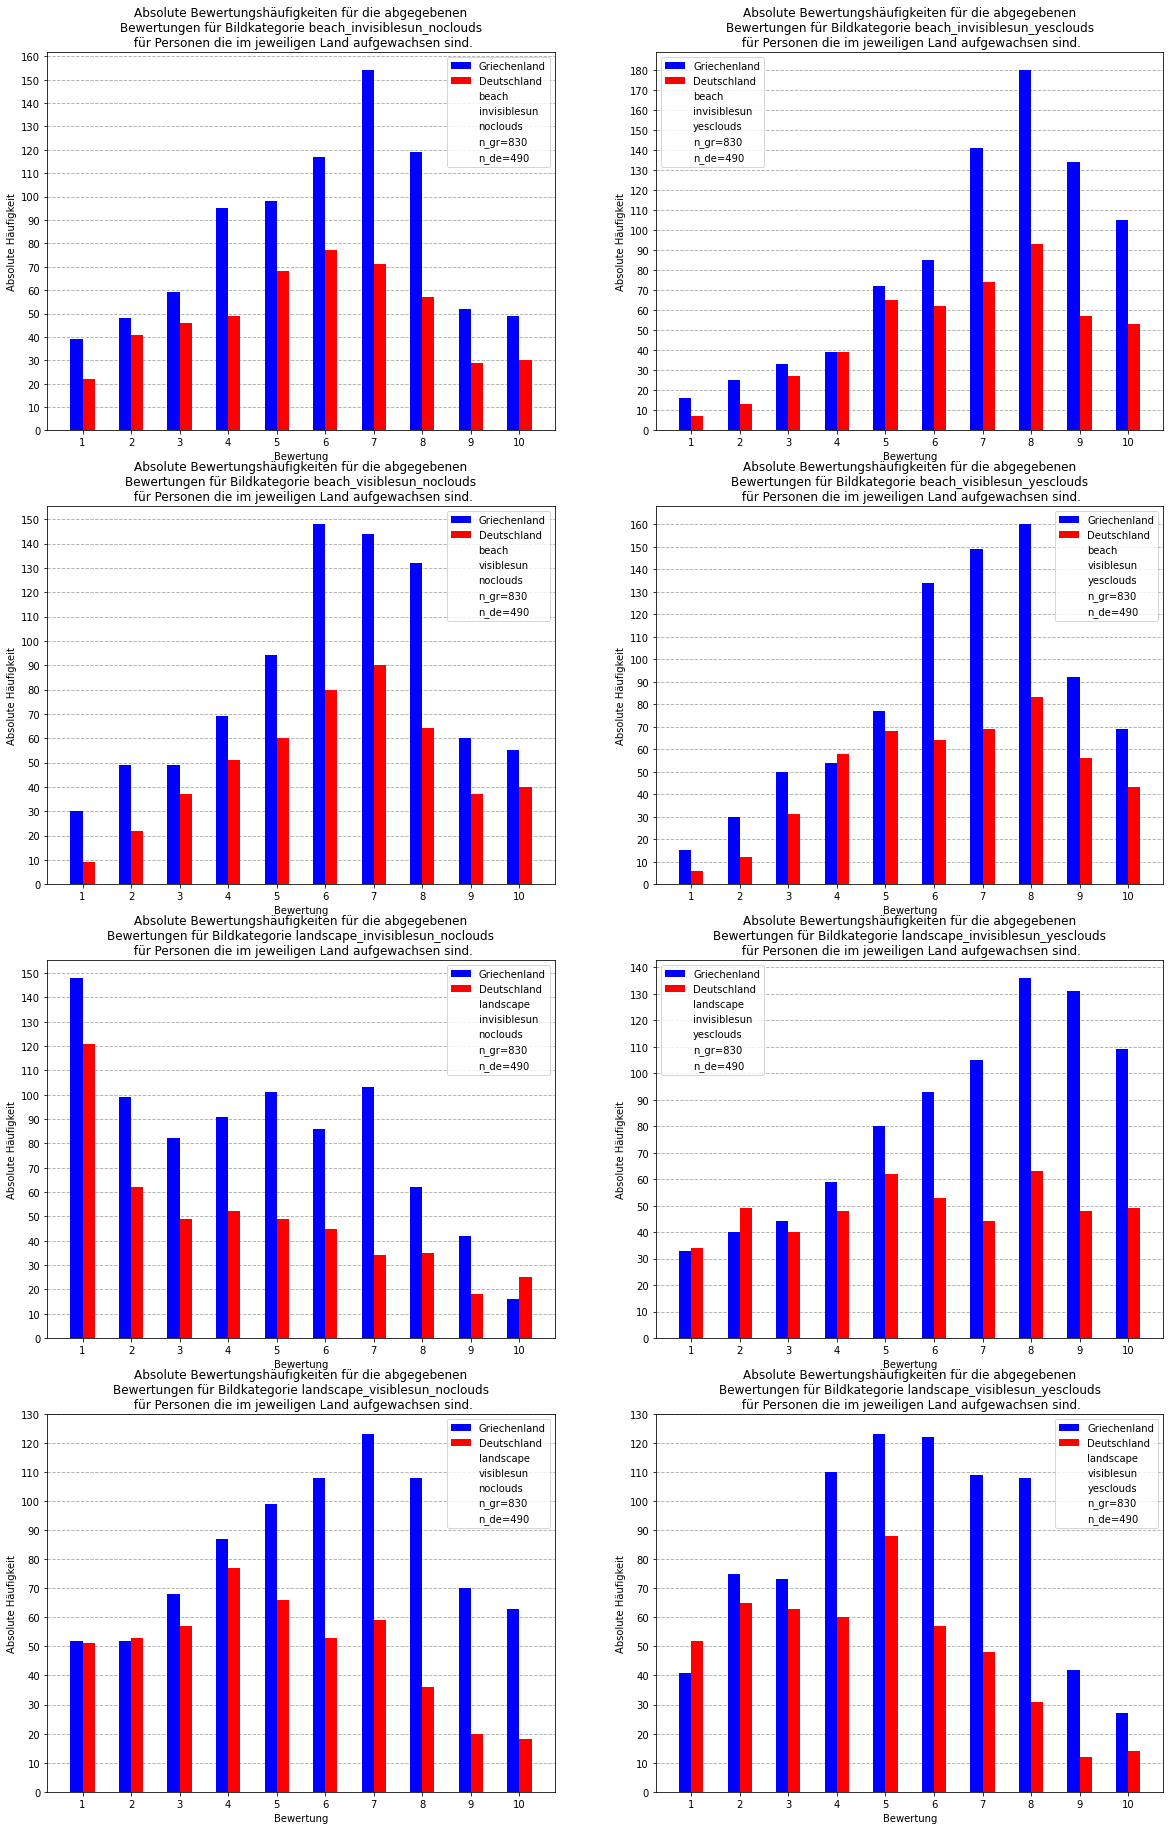

In [19]:
# asdf = (np.arange(0, 3001, 250).astype(np.float64)/100)
# [str(perc)+"%" for perc in asdf]
def plotFrequenciesForEverything():
    fig, axs = plt.subplots(4,2,figsize=(20,4*8))
#     for i in range(0,len(axs)):
#         ax = axs[i]
#     plotFor2DictsOnAx(axs[0], 'beach_invisiblesun_noclouds',cat1_n_gr,cat1_n_de,[cat1GrRatings_avg, cat1DeRatings_avg])
#     plotFor2DictsOnAx(axs[1], 'beach_invisiblesun_yesclouds',cat2_n_gr,cat2_n_de, [cat2GrRatings_avg, cat2DeRatings_avg])
    plotFrequenciesForCategoryOnAx(axs[0][0], 'beach_invisiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[0][1], 'beach_invisiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[1][0], 'beach_visiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[1][1], 'beach_visiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[2][0], 'landscape_invisiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[2][1], 'landscape_invisiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[3][0], 'landscape_visiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[3][1], 'landscape_visiblesun_yesclouds')
    plt.savefig('abs_haeuf.jpg', dpi=150)
    
    
def plotFrequenciesForCategoryOnAx(ax, category):
#     fig, axs = plt.subplots(1,2,figsize=(20,21))
#     gr_ratings_avg, n_gr, de_ratings_avg, n_de = getAveragedDataForCategory(category)
#     plotFor2DictsOnAx(ax, category, n_gr, n_de,[gr_ratings_avg, de_ratings_avg])
    gr_ratings, n_gr, de_ratings, n_de = getAbsoluteDataForCategory(category)
    plotFor2DictsOnAx(ax, category, n_gr, n_de,[gr_ratings, de_ratings])

    
def plotFor2DictsOnAx(ax, imageCategory,n_gr, n_de, ratingsDicts):
# fig = plt.figure(figsize=(10,8))
    width = 0.5
    colors = ['blue', 'red'] #Blue - Greece, Red - Germany
    bars = []
    ymax = 0
    for i, ratingsDict in enumerate(ratingsDicts):
        w = width/2
        x, y = getxyFromDict(ratingsDict)
        if max(y)>ymax:
            ymax=max(y)
        bar = ax.bar(x+(i*w),y,w,color=colors[i], zorder=10)
        bars.append(bar)
    parameters = imageCategory.split('_')
    parameters.append(f"n_gr={n_gr}")
    parameters.append(f"n_de={n_de}")
    for param in parameters:
        emptyBar = ax.bar(1.5,0, alpha=0)
        bars.append(emptyBar)
    ax.set_xticks(x+width/4)
    ax.set_xticklabels(x)
#     ax.set_yticks(np.arange(0,0.3,step=0.025)) #For relative frequencies
    ax.set_yticks(np.arange(0,ymax+10,step=10))
#     ax.set_yticks()
#     ax.set_xticklabels(x)
    ax.set_xlabel(f"Bewertung")
#     ax.set_ylabel(f"Relative Häufigkeit")
    ax.set_ylabel("Absolute Häufigkeit")
    ax.legend(bars, ['Griechenland','Deutschland'] + parameters)#,'beach'])
    ax.grid(ls = '--', lw = 0.9, axis = 'y', zorder = 0)
#     ax.set_title(f"Relative Bewertungshäufigkeiten für die abgegebenen\nBewertungen für Bildkategorie {imageCategory}\n für Personen die im jeweiligen Land aufgewachsen sind.")
    ax.set_title(f"Absolute Bewertungshäufigkeiten für die abgegebenen\nBewertungen für Bildkategorie {imageCategory}\n für Personen die im jeweiligen Land aufgewachsen sind.")
    return bars

plotFrequenciesForEverything()

In [20]:
de_avg_variance = np.average([p.getVariance() for p in dePersons])
de_avg = np.average([p.getAverage() for p in dePersons])
gr_avg_variance = np.average([p.getVariance() for p in grPersons])
gr_avg = np.average([p.getAverage() for p in grPersons])

In [21]:
def getRatingListForCategory(category, homeland):
    categoryImages = imgsDictByCategory[category]
    res_ratings = []
    for img in categoryImages:
        res_ratings += img.getRatingsAsList(homeland)
    return res_ratings
        
def getAllRatingsListForCategory(category):
    categoryImages = imgsDictByCategory[category]
    res_ratings = []
    for img in categoryImages:
        res_ratings += img.getAllRatingsAsList()
    return res_ratings

def getRatingDictForCategory(category, homeland):
    categoryImages = imgsDictByCategory[category]
    ratingScale = categoryImages[0].getRatingDict(homeland).keys()
    res = dict()
    for rating in ratingScale:
        res[rating] = 0
    for img in categoryImages:
        imgRatingDict = img.getRatingDict(homeland)
        for rating in ratingScale:
            res[rating] += imgRatingDict[rating]
    return res

def getN(homeland):
    persons_with_that_homeland = [person for person in persons if person.homeland == homeland]
    return len(persons_with_that_homeland)
# getRatingDictForCategory('beach_invisiblesun_noclouds','gr')
# getRatingListForCategory('beach_invisiblesun_noclouds', 'gr')
# len(getAllRatingsListForCategory('beach_invisiblesun_noclouds'))

In [22]:
def showDataForCategories():
    print("Statistic data for each category:\n")
    for category in imgsDictByCategory.keys():
        deRatings = getRatingListForCategory(category, 'de')
        de_avg = np.average(deRatings)
        de_var = np.var(deRatings)
        de_std = np.std(deRatings)
        
        grRatings = getRatingListForCategory(category, 'gr')
        gr_avg = np.average(grRatings)
        gr_var = np.var(grRatings)
        gr_std = np.std(grRatings)
        
        totalRatings = getAllRatingsListForCategory(category)
        total_avg = np.average(totalRatings)
        total_var = np.var(totalRatings)
        total_std = np.std(totalRatings)
        
        diff_avg = np.abs(de_avg-gr_avg)
        diff_var = np.abs(de_var-gr_var)
        diff_std = np.abs(de_std-gr_std)
        
        gr_rating_dict = getRatingDictForCategory(category,'gr')
        gr_abs_rating_frequencies = np.array(list(gr_rating_dict.values()))
#         gr_abs_rating_frequencies = gr_abs_rating_frequencies/gr_abs_rating_frequencies.sum()
        de_rating_dict = getRatingDictForCategory(category,'de')
        de_abs_rating_frequencies = np.array(list(de_rating_dict.values()))
#         de_abs_rating_frequencies = de_abs_rating_frequencies/de_abs_rating_frequencies.sum()
        
        
        corr_coeff = np.corrcoef(de_abs_rating_frequencies,gr_abs_rating_frequencies)[0,1]
        
        line = f"{category:32}\n"
        line += f"         DE - Avg: {de_avg:4.2f} - Var: {de_var:4.2f} - Std: {de_std:4.2f}\n"
        line += f"         GR - Avg: {gr_avg:4.2f} - Var: {gr_var:4.2f} - Std: {gr_std:4.2f}\n"
        line += f"Differences - Avg: {diff_avg:4.2f} - Var: {diff_var:4.2f} - Std: {diff_std:4.2f}\n"
        line += f"      Total - Avg: {total_avg:4.2f} - Var: {total_var:4.2f} - Std: {total_std:4.2f}\n"
        line += f"Correlation Coefficient of abs. rating frequencies De-Gr: {corr_coeff:4.3f}\n"
        print(line)
    
showDataForCategories()

Statistic data for each category:

beach_invisiblesun_noclouds     
         DE - Avg: 5.62 - Var: 5.82 - Std: 2.41
         GR - Avg: 5.87 - Var: 5.57 - Std: 2.36
Differences - Avg: 0.25 - Var: 0.26 - Std: 0.05
      Total - Avg: 5.78 - Var: 5.68 - Std: 2.38
Correlation Coefficient of abs. rating frequencies De-Gr: 0.882

beach_invisiblesun_yesclouds    
         DE - Avg: 6.68 - Var: 4.96 - Std: 2.23
         GR - Avg: 7.08 - Var: 4.95 - Std: 2.23
Differences - Avg: 0.40 - Var: 0.01 - Std: 0.00
      Total - Avg: 6.93 - Var: 4.99 - Std: 2.23
Correlation Coefficient of abs. rating frequencies De-Gr: 0.908

beach_visiblesun_noclouds       
         DE - Avg: 6.17 - Var: 5.06 - Std: 2.25
         GR - Avg: 6.10 - Var: 5.34 - Std: 2.31
Differences - Avg: 0.07 - Var: 0.28 - Std: 0.06
      Total - Avg: 6.13 - Var: 5.23 - Std: 2.29
Correlation Coefficient of abs. rating frequencies De-Gr: 0.945

beach_visiblesun_yesclouds      
         DE - Avg: 6.45 - Var: 4.93 - Std: 2.22
         GR - 

In [23]:
def calculateStatsForCategories():
#     print("Statistic data for each category:\n")
    stats = dict()
    for category in imgsDictByCategory.keys():
        entry = dict()
        
        deRatings = getRatingListForCategory(category, 'de')
        de_avg = np.average(deRatings)
        de_var = np.var(deRatings)
        de_std = np.std(deRatings)
        
        grRatings = getRatingListForCategory(category, 'gr')
        gr_avg = np.average(grRatings)
        gr_var = np.var(grRatings)
        gr_std = np.std(grRatings)
        
        totalRatings = getAllRatingsListForCategory(category)
        total_avg = np.average(totalRatings)
        total_var = np.var(totalRatings)
        total_std = np.std(totalRatings)
        
        diff_avg = np.abs(de_avg-gr_avg)
        diff_var = np.abs(de_var-gr_var)
        diff_std = np.abs(de_std-gr_std)
        
        gr_rating_dict = getRatingDictForCategory(category,'gr')
        gr_abs_rating_frequencies = np.array(list(gr_rating_dict.values()))
#         gr_abs_rating_frequencies = gr_abs_rating_frequencies/gr_abs_rating_frequencies.sum()
        de_rating_dict = getRatingDictForCategory(category,'de')
        de_abs_rating_frequencies = np.array(list(de_rating_dict.values()))
#         de_abs_rating_frequencies = de_abs_rating_frequencies/de_abs_rating_frequencies.sum()
        
        
        corr_coeff = np.corrcoef(de_abs_rating_frequencies,gr_abs_rating_frequencies)[0,1]
        
        entry['de'] = {
            'avg': de_avg,
            'var': de_var,
            'std': de_std,
             }
        entry['gr'] = {
            'avg': gr_avg,
            'var': gr_var,
            'std': gr_std,
             }
        entry['total'] = {
            'avg': total_avg,
            'var': total_var,
            'std': total_std,
             }
        entry['diff'] = {
            'avg': diff_avg,
            'var': diff_var,
            'std': diff_std
             }
        entry['corr_coeff'] = corr_coeff
        stats[category] = entry
    return stats

In [24]:
allStats = calculateStatsForCategories()
allStats['beach_invisiblesun_noclouds']['diff'], allStats

({'avg': 0.24947135480698268,
  'var': 0.257055785956509,
  'std': 0.053862748687923734},
 {'beach_invisiblesun_noclouds': {'de': {'avg': 5.6204081632653065,
    'var': 5.823256976259891,
    'std': 2.413142551997269},
   'gr': {'avg': 5.869879518072289,
    'var': 5.566201190303382,
    'std': 2.359279803309345},
   'total': {'avg': 5.777272727272727,
    'var': 5.676150137741047,
    'std': 2.3824672374958373},
   'diff': {'avg': 0.24947135480698268,
    'var': 0.257055785956509,
    'std': 0.053862748687923734},
   'corr_coeff': 0.8818211374786769},
  'beach_invisiblesun_yesclouds': {'de': {'avg': 6.677551020408163,
    'var': 4.957251145356103,
    'std': 2.226488523517717},
   'gr': {'avg': 7.0771084337349395,
    'var': 4.950680795471041,
    'std': 2.2250125382727712},
   'total': {'avg': 6.928787878787879,
    'var': 4.9903833792470165,
    'std': 2.2339166007814653},
   'diff': {'avg': 0.3995574133267761,
    'var': 0.006570349885061333,
    'std': 0.0014759852449457433},
   '

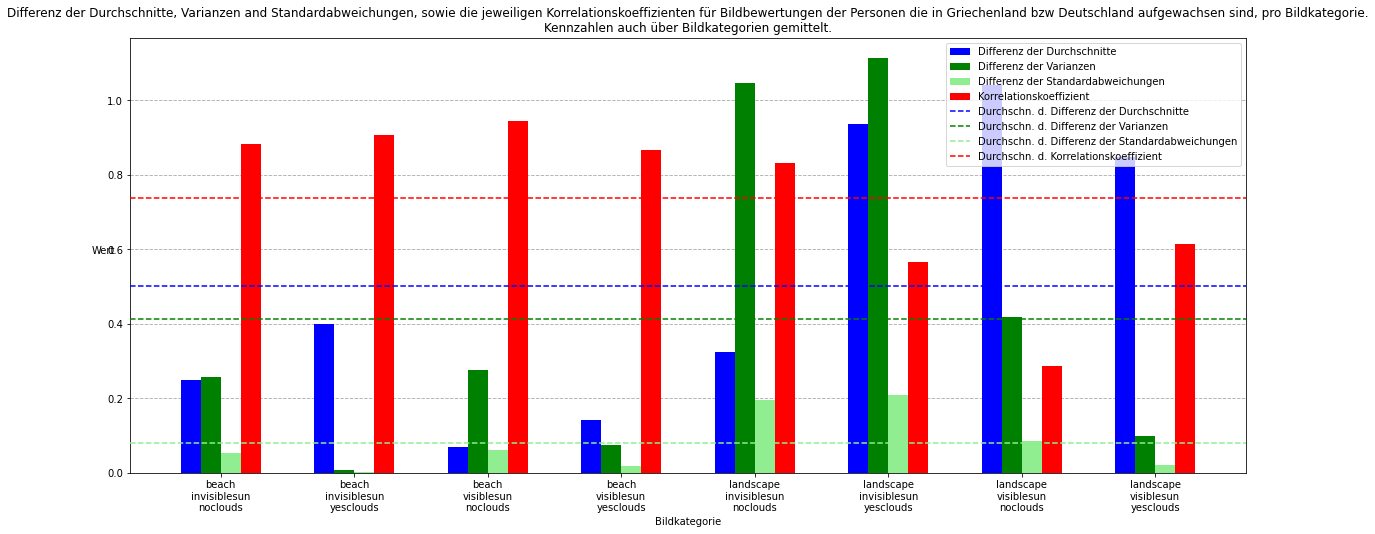

In [25]:
def plotDifferences(stats):
    categories = list(stats.keys())
    indices = np.array(list(range(1, len(categories)+1)))
    colors = ['blue', 'green','lightGreen','red']
    label_ticks = []
    labels = ['\n'.join(cat.split('_')) for cat in categories]
    
    averages = []
    variances = []
    stds = []
    corr_coeffs = []
    toAverage = {'avg': averages, 'var': variances, 'std':stds, 'corr_coeff': corr_coeffs}
    
    width = 0.6
    parameters = ['avg', 'var', 'std']
    w = width/(len(parameters)+1)
    
    fig = plt.figure(figsize=(20,8))
    plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
    bars = []
    for i, category in enumerate(categories):
#         b = plt.bar(category, stats[category]['diff'][parameter])
        for j, param in enumerate(parameters):
#             w = width/(len(parameters)+1)
            x = i +(j*w)+1
            y = stats[category]['diff'][param]
            toAverage[param].append(y)
            b = plt.bar(x,y,w, color=colors[j], zorder=5)
            bars.append(b)
#             label_ticks.append(x)
#             labels.append(param)
#        w = width/(len(parameters)+1)
        x = i +((j+1)*w)+1
        y = stats[category]['corr_coeff']
        toAverage['corr_coeff'].append(y)
#         label_ticks.append(x)
#         labels.append('corr_coeff')
        b = plt.bar(x,y,w, color=colors[j+1],zorder=5)
        bars.append(b)
            
    
    hlines = []
    for i, param in enumerate(parameters):
        hline = plt.axhline(np.average(toAverage[param]), color = colors[i], zorder = 10, ls='--')
        hlines.append(hline)
    hline = plt.axhline(np.average(toAverage['corr_coeff']), color = 'red', zorder = 10, ls='--')   
    hlines.append(hline)
    
#     barLabels = ['Averages Difference', 'Variances Difference', 'Standard Deviations Difference', 'Correlation Coefficient']
#     hlineLabels = ['Average ' + barLabel for barLabel in barLabels]
    barLabels = ['Differenz der Durchschnitte', 'Differenz der Varianzen', 'Differenz der Standardabweichungen', 'Korrelationskoeffizient']
    hlineLabels = ['Durchschn. d. ' + barLabel for barLabel in barLabels]
    plt.legend(bars[0:4] + hlines, barLabels + hlineLabels)
    #Add the average lines
    
    
    plt.xticks(indices+1.5*w,labels)#, rotation=60)
#     plt.xticks(label_ticks, labels, rotation = 45)
#     plt.xlabel("Image Category")
#     plt.ylabel("Value")
    plt.xlabel("Bildkategorie")
    plt.ylabel("Wert", rotation=0)
#     plt.title("Differences of average, variance and standart deviation as well as correlation coefficient for image ratings of people who were raised in Greece vs in Germany for each image category")
    plt.title("Differenz der Durchschnitte, Varianzen and Standardabweichungen, sowie die jeweiligen Korrelationskoeffizienten für Bildbewertungen der Personen die in Griechenland bzw Deutschland aufgewachsen sind, pro Bildkategorie.\nKennzahlen auch über Bildkategorien gemittelt.")
    plt.savefig('differences2.jpg', dpi=150)
    plt.show()
    
plotDifferences(allStats)

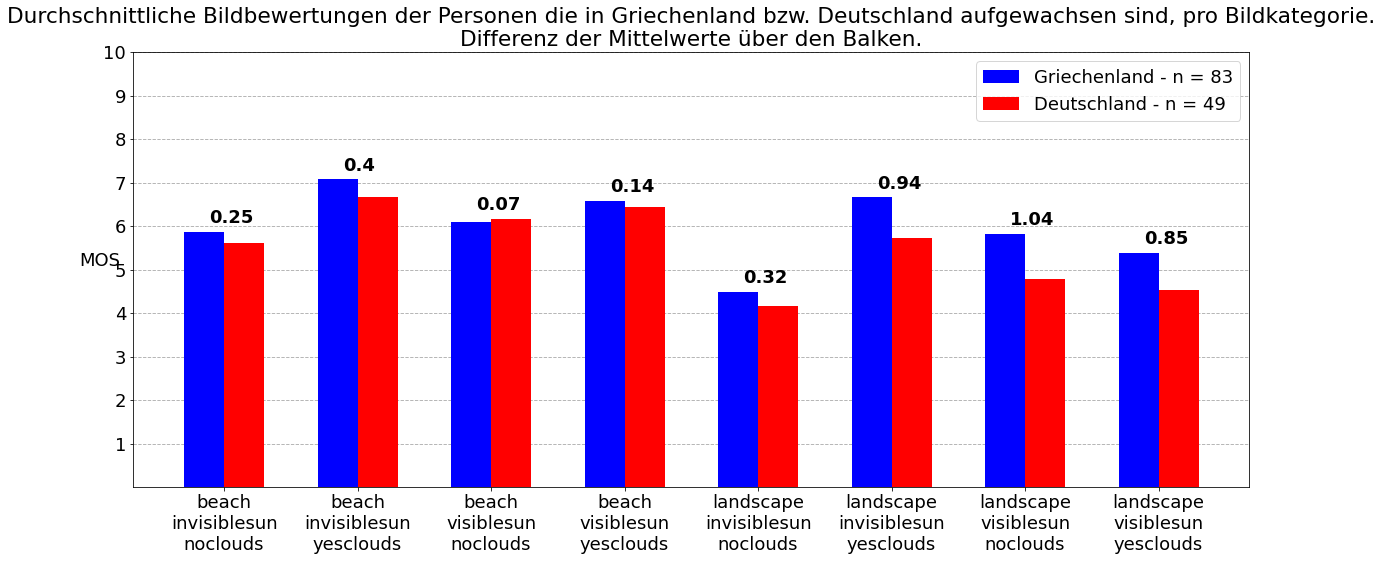

In [26]:
def plotAverages(stats):
    plt.rcParams.update({'font.size': 18})
    categories = list(stats.keys())
    indices = np.array(list(range(1, len(categories)+1)))
    colors = ['blue', 'red']
    homelands = ['gr','de']
    label_ticks = []
    labels = ['\n'.join(cat.split('_')) for cat in categories]
    
    averages = []
#     variances = []
#     stds = []
#     corr_coeffs = []
    toAverage = {'avg': averages}#, 'var': variances, 'std':stds, 'corr_coeff': corr_coeffs}
    
    width = 0.6
    parameters = ['avg']#, 'var', 'std']
    w = width/(len(parameters)+1)
    
    fig = plt.figure(figsize=(20,8))
    plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
    bars = []
    for i, category in enumerate(categories):
        toMax = []
        for j, homeland in enumerate(homelands):
            x = i +(j*w)+1
            y = stats[category][homeland]['avg']
            b = plt.bar(x,y,w, color=colors[j], zorder=5)
            bars.append(b)
            toMax.append(y)
        max_bar_value = max(toMax)
        diff_of_avg = round(stats[category]['diff']['avg'],2)
        plt.text(i+0.5*w+0.89,max_bar_value+0.2, str(diff_of_avg), color='black', fontweight='bold') #Plot the differences as number above the bars
#     emptyBars = []
#     for homeland in homelands:
#         emptyBar = plt.bar(1.5,0, alpha=0)
#         emptyBars.append(emptyBar)
    n_gr = getN('gr')
    n_de = getN('de')
    barLabels = [f'Griechenland - n = {n_gr}',f'Deutschland - n = {n_de}']
#     emptyBarLabels = [f'{n_gr} Versuchspersonen aus Griechenland', f'{n_de} Versuchspersonen aus Deutschland']
    plt.legend(bars[0:2], barLabels)# + emptyBarLabels)

    
    
    plt.xticks(indices+0.5*w,labels)#, rotation=60)
    plt.yticks(range(1,11))
    plt.ylabel("MOS", rotation=0)
    plt.title("Durchschnittliche Bildbewertungen der Personen die in Griechenland bzw. " +
            "Deutschland aufgewachsen sind, pro Bildkategorie.\n" + 
            "Differenz der Mittelwerte über den Balken.")
#     plt.savefig('averages.jpg', dpi=150)
    plt.show()
    
plotAverages(allStats)

## Daten zu den Versuchspersonen

In [27]:
n_gr = getN('gr')
n_de = getN('de')
ages_gr = [p.age for p in grPersons]
genders_gr = [p.gender for p in grPersons]

ages_de = [p.age for p in dePersons]
genders_de = [p.gender for p in dePersons]


print("Aufwachsland: Griechenland")
print(f"n: {n_gr}")
print(f"Alter: {min(ages_gr)}-{max(ages_gr)}, durchschnittliches Alter von {round(np.average(ages_gr),2)} und Standardabweichung von {round(np.std(ages_gr),2)}")
print(f"Weiblich: {genders_gr.count('f')}, Männlich: {genders_gr.count('m')}, Andere: {genders_gr.count('x')}")
print("")
print("Aufwachsland: Deutschland")
print(f"n: {n_de}")
print(f"Alter: {min(ages_de)}-{max(ages_de)}, durchschnittliches Alter von {round(np.average(ages_de),2)} und Standardabweichung von {round(np.std(ages_de),2)}")
print(f"Weiblich: {genders_de.count('f')}, Männlich: {genders_de.count('m')}, Andere: {genders_de.count('x')}")


Aufwachsland: Griechenland
n: 83
Alter: 18-62, durchschnittliches Alter von 27.36 und Standardabweichung von 10.72
Weiblich: 41, Männlich: 40, Andere: 2

Aufwachsland: Deutschland
n: 49
Alter: 21-68, durchschnittliches Alter von 33.2 und Standardabweichung von 11.02
Weiblich: 21, Männlich: 27, Andere: 1


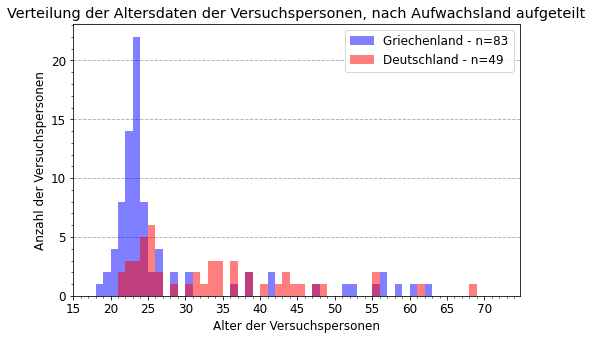

In [28]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,5))
bins = np.arange(min(ages_gr+ages_de), max(ages_gr+ages_de)+5, 1.0)
plt.hist(ages_gr, bins,alpha=0.5, color='blue', label=f'Griechenland - n={n_gr}',zorder=10)
plt.hist(ages_de, bins,alpha=0.5, color='red', label=f'Deutschland - n={n_de}',zorder=10)
plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
# plt.xticks(np.arange(min(ages_gr+ages_de), max(ages_gr+ages_de)+5, 5.0))
plt.xticks(np.arange(15, max(ages_gr+ages_de)+5, 5.0))
plt.xlabel("Alter der Versuchspersonen")
plt.ylabel("Anzahl der Versuchspersonen")
plt.title("Verteilung der Altersdaten der Versuchspersonen, nach Aufwachsland aufgeteilt")
plt.legend()
plt.minorticks_on()
# plt.savefig('alter_versuchspersonen.jpg', dpi=150)
plt.show()

# Von hier an werden die Hypothesen überprüft (einige Texte sind veraltet oder unpassend - in der Abgabe wurde dies bereits geändert)

In [ ]:
#For t-tests
import pandas as pd
import scipy.stats as stats
import researchpy as rp
from IPython.display import Markdown as md
#For ANOVA:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#For Tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Hypothese 1
### Wenn der Aufwachsort der Versuchspersonen für die ästhetische Wahrnehmung von Sonnenuntergangsbildern eine Rolle spielt, dann sollten sich die MOS bei der Beurteilung von Bildern von Deutschen und Griechen unterscheiden.
Hierfür wird ein <b>t-Test für unabhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: Bildbewertungen von Personen die in <b>Griechenland</b> aufgewachsen sind<br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: Bildbewertungen von Personen die in <b>Deutschland</b> aufgewachsen sind<br>
Es wird der Einfluss von<br>
<b>X: Aufwachsort der Versuchspersonen</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Stichproben sind unabhänhig</u>: <b>Liegt vor</b>, da 2 individuelle Gruppen von Versuchspersonen geprüft werden, welche keinen Einfluss aufeinander haben.</li>
    <li>Das <u>untersuchte Merkmal ist in den Grundgesamtheiten der beiden Gruppen normalverteilt</u>: Das <b>muss überprüft werden</b></li>
    <li>Die <u>Varianzen der Stichproben müssen homogen sein</u>: Das <b>muss überprüft werden</b></li>
</ol>

#### 2. Ist die Differenz der MOS der Bildbewertungen bei beiden Gruppen normalverteilt?

Laut dem Zentralen Grenzwertsatz (ZGS) der Statistik wird die Stichprobenverteilung des standardisierten
Stichprobenmittelwerts bei wachsender Stichprobengröße $n$ der Standardnormalverteilung immer ähnlicher. Die Dauemenregel besagt dabei eine Stichprobengröße von $n\geq30$. Dies ist für beide Stichproben zutreffend. Somit wird davon ausgegangen, dass die Bildbewertungen von Personen die in Griechenland sowie in Deutschland aufgewachsen sind in ihrer Grundgesamtheit normalverteilt sind.

In [ ]:
#Shapiro-Wilk (SW) Test für Normalität
mos_gr = np.array([p.getAverage() for p in grPersons])
mos_de = np.array([p.getAverage() for p in dePersons])
minSize = min(len(mos_gr), len(mos_de))
print("Cutting size down to:",minSize)
sampling_difference_hyp_1 = mos_gr[0:minSize] - mos_de[0:minSize]
shapiro_result = stats.shapiro(sampling_difference_hyp_1)#Wenn p < 0.05 --> Daten sind nicht normalverteilt
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")
#np.average(mos_gr),np.average(mos_de),np.average(sampling_difference_hyp_1)

#### 3. Sind die Varianzen der Stichproben homogen?

In [ ]:
levene_result = stats.levene(mos_gr,mos_de)
print(levene_result)
if(levene_result.pvalue>0.05):
    print("Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, kann nicht abgelehnt werden, da p>0.05.")
    print("Die 2 Stichproben haben demnach höchstwahrscheinlich homogene Varianzen.")
else:
    print("Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, wurde abgelehnt, da p<0.05.")
    print("Die 2 Stichproben haben demnach höchstwahrscheinlich inhomogene Varianzen.")

#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [ ]:
#Create the dataframe
col1_header = 'Aufwachsort'
col2_header = 'MOS'
col1_vals = []
col2_vals = []
for mos in mos_gr:
    col1_vals.append('gr')
    col2_vals.append(mos)
for mos in mos_de:
    col1_vals.append('de')
    col2_vals.append(mos)
data_hyp_1 = {col1_header:col1_vals, col2_header:col2_vals}
df_hyp_1 = pd.DataFrame(data_hyp_1)
# df_hyp_1

In [ ]:
#Execute the t-Test
#Trimming überlegen aufgrund von einer Menge von Ausreißern?
summary_hyp_1, results_hyp_1 = rp.ttest(group1=df_hyp_1['MOS'][df_hyp_1['Aufwachsort'] == 'gr'], group1_name="MOS von Personen mit GR Aufwachsort",
                            group2=df_hyp_1['MOS'][df_hyp_1['Aufwachsort'] == 'de'], group2_name="MOS von Personen mit DE Aufwachsort")

In [ ]:
summary_hyp_1

In [ ]:
results_hyp_1

In Zeile 3 lässt sich der Wert p = 0.3324 ablesen. Dieser ist größer als das Signifikanzniveau 0.05, somit kann die Nullhypothese NICHT abgelehnt werden, was bedeutet, dass sich die MOS der Personen die in Griechenland aufgewachsen sind, von den MOS der Personen die in Detuschland aufgewachsen sind bei einem Freiheitsgrad von $f=104$ und Stichprobengrößen von respektive 61 und 45 statistisch NICHT signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt lediglich 0.35 Skalenpunkte. <br>
<!-- Das bedeutet, dass Personen die in Griechenland aufgewachsen sind um 0.35 Skalenpunkte höher bewerten, als Personen die in Deutschland aufgewachsen sind.<br> -->
<b>Die 1. Hypothese ist somit widerlegt.</b>

In [ ]:
#Pearson-Produkt-Momentkorrelation r NUR FUER n1=n2
# def calcPearson(t, df):
#     r = np.power(t,2) / ( np.power(t,2) + df )
#     r = np.sqrt(r)
#     return r

# def interpretPearson(r):
#     print("r =",r)
#     if (r>=0.1 and r<0.3):
#         print("Der Effekt ist schwach.")
#     elif()
def calculateCohen(t, n1, n2):
    d = 1/n1 + 1/n2
    d = np.sqrt(d)
    d = t*d
    return d

def interpretCohen(d):
    print("Cohen's d =",d)
    d_abs = np.abs(d)
    if (d_abs>=0.2 and d_abs<0.5):
        print("Der Effekt ist schwach.")
    elif(d_abs>=0.5 and d<0.8):
        print("Der Effekt ist mittelstark.")
    elif(d_abs>=0.8):
        print("Der Effekt ist stark.")
    else:
        print("Der Effekt ist minimal(?).")

In [ ]:
# np.average([allStats[category]['diff']['avg'] for category in allStats.keys()])
gr_avg, de_avg

In [ ]:
# d_hyp1 = calculateCohen(results_hyp_1['results'][2], summary_hyp_1['N'][0],summary_hyp_1['N'][1])
interpretCohen(results_hyp_1['results'][6])

## Hypothese 2
### Wenn die Präsenz von Wolken auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielt, dann sollten die MOS von Bildern mit Wolken sich von denen ohne Wolken unterscheiden.
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: MOS von Bildern <b>mit Wolken</b><br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: MOS von Bildern <b>ohne Wolken</b><br>
Es wird der Einfluss von<br>
<b>X: Präsenz von Wolken auf dem Bild</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Messwertpaare</u> der verbundenen Stichproben sind <u>voneinander unabhänhig</u>: <b>Liegt vor</b>, da dieselbe Gruppe von Versuchspersonen geprüft wird, und zwar für unterschiedliche Typen von Bildern, welche keinen Einfluss aufeinander haben.</li>
    <li>Die <u>Unterschiede zwischen den verbundenen Testwerten sind in der Grundgesamtheit normalverteilt</u> (ab $n>30$ sind Verletzungen unproblematisch): Das <b>muss nicht überprüft werden</b>, da jeweils $n=60$ Personen</li>
</ol>

#### 2. Ist die Differenz der MOS der Bilder mit und ohne Wolken normalverteilt?

In [ ]:
categories_yes_clouds = [cat for cat in imgsDictByCategory.keys() if 'yesclouds' in cat]
categories_no_clouds = [cat for cat in imgsDictByCategory.keys() if 'noclouds' in cat]

In [ ]:
def getAverageForCategories(person, categories):
    categoryStatsDict = person.getCategoryStatsDict()
    ratingsForCategory = []
    for cat in categories:
        ratingsForCategory.append(categoryStatsDict[cat]['average'])
    return np.average(ratingsForCategory)

In [ ]:
mos_ohne_wolken = np.array([getAverageForCategories(person, categories_no_clouds) for person in persons])
mos_mit_wolken = np.array([getAverageForCategories(person, categories_yes_clouds) for person in persons])
sampling_difference_hyp_2 = mos_ohne_wolken-mos_mit_wolken
np.average(mos_ohne_wolken), np.average(mos_mit_wolken), len(mos_ohne_wolken), len(mos_mit_wolken)

In [ ]:
# mos_ohne_wolken_old = np.array([image.getAllAverage() for image in allImgs if image.cloudVisibility=='noclouds'])
# mos_mit_wolken_old = np.array([image.getAllAverage() for image in allImgs if image.cloudVisibility=='yesclouds'])
# np.average(mos_ohne_wolken_old), np.average(mos_mit_wolken_old)
np.where(sampling_difference_hyp_2<-3), sampling_difference_hyp_2[114], sampling_difference_hyp_2[130]
sampling_difference_hyp_2_adjusted = np.array(sampling_difference_hyp_2)
print(len(sampling_difference_hyp_2_adjusted))
sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 130)
sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 114)
# sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 10)
# sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, -1)
print(len(sampling_difference_hyp_2_adjusted))
np.argwhere(sampling_difference_hyp_2_adjusted<-2.5)
print(persons[130],persons[114])

In [ ]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference_hyp_2_adjusted, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [ ]:
shapiro_result = stats.shapiro(sampling_difference_hyp_2_adjusted)
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")

#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [ ]:
#Create the dataframe
hyp_2_col1_header = 'noclouds'
hyp_2_col2_header = 'yesclouds'
hyp_2_col1_vals = mos_ohne_wolken
hyp_2_col2_vals = mos_mit_wolken
data_hyp_2 = {hyp_2_col1_header:hyp_2_col1_vals, hyp_2_col2_header:hyp_2_col2_vals}
df_hyp_2 = pd.DataFrame(data_hyp_2)

In [ ]:
print(stats.ttest_rel(df_hyp_2['noclouds'], df_hyp_2['yesclouds']))
summary_hyp_2, results_hyp_2 = rp.ttest(group1=df_hyp_2['noclouds'], group1_name="MOS von Bildern ohne Wolken",
                            group2=df_hyp_2['yesclouds'], group2_name="MOS von Bildern mit Wolken", paired=True)

In [ ]:
summary_hyp_2

In [ ]:
results_hyp_2

In [ ]:
avg_mit_wolken = np.average(mos_mit_wolken)
avg_ohne_wolken = np.average(mos_ohne_wolken)
differenz_hyp_2 = avg_mit_wolken - avg_ohne_wolken
print(f"Durchschnittliche Bewertung ohne Wolken:", round(avg_ohne_wolken,2))
print(f"Durchschnittliche Bewertung mit Wolken", round(avg_mit_wolken,2))
print(f"Differenz von:", round(differenz_hyp_2,2))
interpretCohen(results_hyp_2['results'][6])

Der p-Wert beträgt 0.0065. Dieser ist viel kleiner als das Signifikanzniveau 0.05, somit kann die Nullhypothese abgelehnt werden, was bedeutet, dass sich die MOS von Bildern ohne Wolken, von den MOS von Bildern mit Wolken bei einem Freiheitsgrad von $f=60-1=59$ und Stichprobengrößen von jeweils $n=60$ Personen statistisch signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt 0.74 Skalenpunkte. Das bedeutet, dass Bilder mit Wolken um 0.74 Skalenpunkte höher bewertet werden, als Bilder ohne Wolken.<br>
<b>Die 2. Hypothese ist somit bestätigt.</b>

## Hypothese 3
### Wenn die Präsenz von Stränden oder Meeren auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielt, dann sollten die MOS von Bildern mit Strand oder Meer sich von denen mit Landschaft unterscheiden. 
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: MOS von Bildern <b>mit Meer</b><br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: MOS von Bildern <b>ohne Meer</b><br>
Es wird der Einfluss von<br>
<b>X: Präsenz von Meer auf dem Bild</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Messwertpaare</u> der verbundenen Stichproben sind <u>voneinander unabhänhig</u>: <b>Liegt vor</b>, da dieselbe Gruppe von Versuchspersonen geprüft wird, und zwar für unterschiedliche Typen von Bildern, welche keinen Einfluss aufeinander haben.</li>
    <li>Die <u>Unterschiede zwischen den verbundenen Testwerten sind in der Grundgesamtheit normalverteilt</u> (ab $n>30$ sind Verletzungen unproblematisch): Das <b>muss nicht überprüft werden</b>, da jeweils $n=40$ Bilder</li>
</ol>

#### 2. Ist die Differenz der MOS der Bilder mit und ohne Wolken normalverteilt?

In [ ]:
categories_beach = [cat for cat in imgsDictByCategory.keys() if 'beach' in cat]
categories_landscape = [cat for cat in imgsDictByCategory.keys() if 'landscape' in cat]
mos_ohne_meer = np.array([getAverageForCategories(person, categories_beach) for person in persons])
mos_mit_meer = np.array([getAverageForCategories(person, categories_landscape) for person in persons])
# mos_ohne_meer = np.sort([image.getAllAverage() for image in allImgs if image.environment!='beach'])
# mos_mit_meer = np.sort([image.getAllAverage() for image in allImgs if image.environment=='beach'])
sampling_difference_hyp_3 = mos_ohne_meer - mos_mit_meer
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference_hyp_3, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [ ]:
shapiro_result = stats.shapiro(mos_ohne_meer-mos_mit_meer)
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")

#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [ ]:
#Create the dataframe
hyp_3_col1_header = 'landscape'
hyp_3_col2_header = 'beach'
hyp_3_col1_vals = mos_ohne_meer
hyp_3_col2_vals = mos_mit_meer
data_hyp_3 = {hyp_3_col1_header:hyp_3_col1_vals, hyp_3_col2_header:hyp_3_col2_vals}
df_hyp_3 = pd.DataFrame(data_hyp_3)

In [ ]:
print(stats.ttest_rel(mos_ohne_meer, mos_mit_meer))
summary_hyp_3, results_hyp_3 = rp.ttest(group1=df_hyp_3['landscape'], group1_name="MOS von Bildern mit Landschaft",
                            group2=df_hyp_3['beach'], group2_name="MOS von Bildern mit Meer", paired=True)

In [ ]:
summary_hyp_3

In [ ]:
results_hyp_3

In [ ]:
avg_mit_meer = np.average(mos_mit_meer)
avg_ohne_meer = np.average(mos_ohne_meer)
differenz_hyp_2 = avg_mit_meer - avg_ohne_meer
print(f"Durchschnittliche Bewertung ohne Meer:", round(avg_ohne_meer,2))
print(f"Durchschnittliche Bewertung mit Meer", round(avg_mit_meer,2))
print(f"Differenz von:", round(differenz_hyp_2,2))
interpretCohen(results_hyp_3['results'][6])

Der p-Wert beträgt $0.0085\cdot10^{-10}$, ist also fast 0. Dieser ist deutlich kleiner als das Signifikanzniveau 0.05, somit kann die Nullhypothese abgelehnt werden, was bedeutet, dass sich die MOS von Bildern ohne Meer/Strand, von den MOS von Bildern mit Meer/Strand bei Stichprobengrößen von jeweils $n=40$ Bildern  und einem Freiheitsgrad von $f=40-1=39$ statistisch signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt 1.52 Skalenpunkte. Das bedeutet, dass Bilder ohne Meer/Strand um 1.52 Skalenpunkte höher bewertet wurden, als Bilder mit Meer/Strand.<br>
<b>Die 3. Hypothese ist somit widerlegt. Der umgekehrte Fall der 3. Hypothese ist jedoch zutreffend.</b>

## Hypothese 4
### Wenn der Aufwachsort der Versuchspersonen und die Präsenz von Landschaften auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielen, dann sollten die MOS von Bildern mit Landschaft bei der Beurteilung von Deutschen höher sein, als bei der Beurteilung von Griechen.
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: Personen mit <b>GR</b> Aufwachsort<br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: Personen mit <b>DE</b> Aufwachsort<br>
Es wird der Einfluss von<br>
<b>X1: Aufwachsort der Versuchsperson</b> (GR oder DE)<br>
<b>X2: Umgebung der Bilder</b> (Landschaft oder Meer)<br>
auf<br>
<b>Y: MOS der Landschaftsbilder von Deutschen > MOS der Landschaftsbilder von Griechen </b>
untersucht.

In [ ]:
person.

In [ ]:
dataDictHyp4 = {'Person': [],
                'Aufwachsort':[],
                'Umgebung':[],
                'MOS':[]}

for p, person in enumerate(persons):
    for env in ['landscape','beach']:
        dataDictHyp4['Person'].append('P%d' % p)
        dataDictHyp4['Aufwachsort'].append(person.homeland)
        dataDictHyp4['Umgebung'].append(env)
        if (env=='landscape'):
            dataDictHyp4['MOS'].append(getAverageForCategories(person, categories_landscape))
        elif (env=='beach'):
            dataDictHyp4['MOS'].append(getAverageForCategories(person, categories_beach))
        else:
            print("ERROR")
            break
df_hyp_4 = pd.DataFrame(dataDictHyp4)
df_hyp_4.to_csv('dataframe_hyp4.csv', index=False)




In [ ]:
# continues in R ....


In [ ]:
#de_landscape = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'de'][df_hyp_4['Umgebung'] == 'landscape']
#gr_landscape = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'gr'][df_hyp_4['Umgebung'] == 'landscape']
#de_beach = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'de'][df_hyp_4['Umgebung'] == 'beach']
#gr_beach = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'gr'][df_hyp_4['Umgebung'] == 'beach']
#de_landscape = list(de_landscape)
#gr_landscape = list(gr_landscape)
#de_beach = list(de_beach)
#gr_beach = list(gr_beach)
#groupData = de_landscape + gr_landscape + de_beach + gr_beach
#groupData=np.array(groupData)
#repetitions_de = len(de_landscape)
#repetitions_gr = len(gr_beach)
#assert(len(de_landscape)==len(de_beach))
#assert(len(gr_landscape)==len(gr_beach))
#groupNames = np.array(['de_landscape']*repetitions_de + ['gr_landscape']*repetitions_gr + ['de_beach']* repetitions_de + ['gr_beach']*repetitions_gr)
#tukey = pairwise_tukeyhsd(groupData,groupNames)
#print(tukey.summary())
#tukey.plot_simultaneous()#comparison_name="de_landscape")
# plt.savefig("tukey.jpg",dpi=150)
#plt.show()

In [ ]:
#results_as_html = tukey.summary().as_html()
#tukey_res = pd.read_html(results_as_html, header=0, index_col=0)[0]
#tukey_res